# Credit Card Fraud Detection

## Problem Statement: 
The incidence of fraudulent activities has multiplied, with FY'19 witnessing approximately 52,304 cases of credit/debit card fraud. Given this significant surge in banking frauds, it is imperative to promptly identify these deceitful transactions to safeguard both consumers and banks, which are experiencing a daily erosion of their creditworthiness. Each instance of fraudulent credit card transactions represents a direct financial setback for the bank, as it bears responsibility for these illicit activities, adversely impacting overall customer satisfaction. The objective of this project is to employ machine learning models for the detection and prediction of fraudulent credit card transactions.


In [1]:
#!pip install pandas seaborn matplotlib scikit-learn
#!pip install xgboost
# Installing scikit-optimize
#!pip install scikit-optimize
#!pip install imbalanced-learn


In [2]:
# Importing Python libraries
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing machine learning and statistics libraries
import sklearn
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Importing additional libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Installing scikit-optimize
!pip install scikit-optimize
from skopt import BayesSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Function to plot the confusion matrix.
    
    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    class_names = ['Non-Fraudulent', 'Fraudulent']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    labels = [['True Negative (TN)', 'False Positive (FP)'], 
              ['False Negative (FN)', 'True Positive (TP)']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(labels[i][j]) + " = " + str(cm[i][j]), fontsize=12)
    plt.show()


# KNN Model Function

In [4]:
import pandas as pd

def KNN_Model(df_results, data_imbalance, X_train, y_traian, X_test, y_test):
    """
    Build and evaluate KNN models.

    Parameters:
    - df_results: DataFrame to store the model results
    - data_imbalance: Data imbalance handling method
    - X_train, y_train: Training dataset features and labels
    - X_test, y_test: Test dataset features and labels
    """

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics
    from sklearn.metrics import roc_auc_score

    # Create KNN model and fit it with the training dataset
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=16)
    knn.fit(X_train, y_train)
    model_score = knn.score(X_test, y_test)
    print("Model Score: {0}".format(model_score))

    # Accuracy
    y_pred = knn.predict(X_test)
    knn_accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Confusion Matrix")
    plot_confusion_matrix(y_test, y_pred)
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    # Predict probabilities using KNN model
    knn_probs = knn.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    knn_roc_value = roc_auc_score(y_test, knn_probs)
    print("KNN ROC Value: {0}".format(knn_roc_value))

    fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
    threshold = thresholds[np.argmax(tpr - fpr)]
    print("KNN Threshold: {0}".format(threshold))

    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the Test Dataset", '{:.1%}'.format(roc_auc))
    plt.plot(fpr, tpr, label="Test, AUC=" + str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    # Create a DataFrame for KNN results
    df_knn = pd.DataFrame({'Data_Imbalance_Handling': data_imbalance,
                           'Model': 'KNN',
                           'Accuracy': model_score,
                           'ROC_Value': knn_roc_value,
                           'Threshold': threshold}, index=[0])

    # Concatenate with existing results
    df_results = pd.concat([df_results, df_knn], ignore_index=True)

    return df_results


# Logistic Regression Model Function

In [5]:
def LR_model(df_Results, DataImabalance, X_train,y_train, X_test, y_test ):

  # Logistic Regression
  from sklearn import linear_model #import the package
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10, 10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )

  searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C
          ,penalty='l1'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='liblinear'
          ,tol=10
      )
  #searchCV.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  searchCV_l1.fit(X_train, y_train)
  print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())
  print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())

  print("Parameters for l2 regularisations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_) 
  print(searchCV_l2.scores_) 

  print("Parameters for l1 regularisations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_) 
  print(searchCV_l1.scores_) 


  #find predicted vallues
  y_pred_l2 = searchCV_l2.predict(X_test)
  y_pred_l1 = searchCV_l1.predict(X_test)
  

  #Find predicted probabilities
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1] 
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1] 

  # Accuaracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuarcy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  plot_confusion_matrix(y_test, y_pred_l2)
  print("classification Report")
  print(classification_report(y_test, y_pred_l2))
  print("Accuarcy of Logistic model with l1 regularisation : {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  plot_confusion_matrix(y_test, y_pred_l1)
  print("classification Report")
  print(classification_report(y_test, y_pred_l1))

  from sklearn.metrics import roc_auc_score
  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}" .format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold_2 = thresholds[np.argmax(tpr-fpr)]
  print('Threshold value',threshold_2)
  print("l2 threshold: {0}".format(threshold_2))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  # Append data to DataFrame
  # Create a DataFrame for l2 regularization results
  df_l2 = pd.DataFrame({'Data_Imbalance_Handling': DataImabalance,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': Accuracy_l2,'ROC_Value': l2_roc_value,'Threshold': threshold_2}, index=[0])
  # Concatenate with existing results
  df_Results = pd.concat([df_Results, df_l2], ignore_index=True)
  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}" .format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold_1 = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold_1))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
  plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()
  
  # Append data to DataFrame
  df_l1 = pd.DataFrame({'Data_Imbalance_Handling': DataImabalance,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': Accuracy_l1,'ROC_Value': l1_roc_value,'Threshold': threshold_1}, index=[0])
  # Concatenate with existing results
  df_Results = pd.concat([df_Results, df_l1], ignore_index=True)

  return df_Results


# SVM Model Function

In [6]:
import pandas as pd

def SVM_Model(df_results, data_imbalance, X_train, y_train, X_test, y_test):
    """
    Build and evaluate SVM models with sigmoid kernel.

    Parameters:
    - df_results: DataFrame to store the model results
    - data_imbalance: Data imbalance handling method
    - X_train, y_train: Training dataset features and labels
    - X_test, y_test: Test dataset features and labels
    """

    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # Evaluate SVM model with sigmoid kernel
    clf = SVC(kernel='sigmoid', random_state=42)
    clf.fit(X_train, y_train)
    y_pred_svm = clf.predict(X_test)
    svm_score = accuracy_score(y_test, y_pred_svm)
    
    print("Accuracy Score: {0}".format(svm_score))
    print("Confusion Matrix")
    plot_confusion_matrix(y_test, y_pred_svm)
    print("Classification Report")
    print(classification_report(y_test, y_pred_svm))

    # Run classifier with probability estimation
    classifier = SVC(kernel='sigmoid', probability=True)
    svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    roc_value = roc_auc_score(y_test, svm_probs)
    print("SVM ROC Value: {0}".format(roc_value))
    
    fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
    threshold = thresholds[np.argmax(tpr - fpr)]
    print("SVM Threshold: {0}".format(threshold))
    
    roc_auc = roc_auc_score(y_test, svm_probs)
    print("ROC for the Test Dataset", '{:.1%}'.format(roc_auc))
    plt.plot(fpr, tpr, label="Test, AUC=" + str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    # Create a DataFrame for SVM results
    df_svm = pd.DataFrame({'Data_Imbalance_Handling': data_imbalance,
                           'Model': 'SVM',
                           'Accuracy': svm_score,
                           'ROC_Value': roc_value,
                           'Threshold': threshold}, index=[0])

    # Concatenate with existing results
    df_results = pd.concat([df_results, df_svm], ignore_index=True)

    return df_results


# DT Model Fuction

In [7]:
import pandas as pd

def DT_Model(df_results, data_imbalance, X_train, y_train, X_test, y_test):
    """
    Build and evaluate Decision Tree models with 'gini' and 'entropy' criteria.

    Parameters:
    - df_results: DataFrame to store the model results
    - data_imbalance: Data imbalance handling method
    - X_train, y_train: Training dataset features and labels
    - X_test, y_test: Test dataset features and labels
    """

    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    criteria = ['gini', 'entropy']
    
    for criterion in criteria:
        # Create Decision Tree model with specified criterion
        dt = DecisionTreeClassifier(criterion=criterion, random_state=42)
        dt.fit(X_train, y_train)
        
        # Evaluate the model on the test set
        y_pred = dt.predict(X_test)
        test_score = dt.score(X_test, y_test)
        
        # Calculate ROC AUC
        tree_preds = dt.predict_proba(X_test)[:, 1]
        tree_roc_value = roc_auc_score(y_test, tree_preds)
        
        print("{0} score: {1}".format(criterion.capitalize(), test_score))
        print("Confusion Matrix")
        plot_confusion_matrix(y_test, y_pred)
        print("Classification Report")
        print(classification_report(y_test, y_pred))
        print("{0} tree_roc_value: {1}".format(criterion.capitalize(), tree_roc_value))
        
        # Find optimal threshold
        fpr, tpr, thresholds = roc_curve(y_test, tree_preds)
        threshold = thresholds[np.argmax(tpr - fpr)]
        print("Tree Threshold: {0}".format(threshold))
        
        # Plot ROC Curve
        roc_auc = roc_auc_score(y_test, tree_preds)
        print("ROC for the Test Dataset", '{:.1%}'.format(roc_auc))
        plt.plot(fpr, tpr, label="Test, AUC=" + str(roc_auc))
        plt.legend(loc=4)
        plt.show()

        # Create a DataFrame for Decision Tree results
        df_tree = pd.DataFrame({'Data_Imbalance_Handling': data_imbalance,
                                'Model': f'Tree Model with {criterion.capitalize()} Criterion',
                                'Accuracy': test_score,
                                'ROC_Value': tree_roc_value,
                                'Threshold': threshold}, index=[0])

        # Concatenate with existing results
        df_results = pd.concat([df_results, df_tree], ignore_index=True)

    return df_results


# Random Forest Model Function

In [8]:
import pandas as pd

def RF_Model(df_results, data_imbalance, X_train, y_train, X_test, y_test):
    """
    Build and evaluate Random Forest model.

    Parameters:
    - df_results: DataFrame to store the model results
    - data_imbalance: Data imbalance handling method
    - X_train, y_train: Training dataset features and labels
    - X_test, y_test: Test dataset features and labels
    """

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # Create Random Forest model with 100 trees
    rf_model = RandomForestClassifier(n_estimators=100, 
                                      bootstrap=True,
                                      max_features='sqrt', 
                                      random_state=42)

    # Fit the model on training data
    rf_model.fit(X_train, y_train)
    rf_test_score = rf_model.score(X_test, y_test)

    print('Model Accuracy: {0}'.format(rf_test_score))

    # Actual class predictions
    rf_predictions = rf_model.predict(X_test)

    print("Confusion Matrix")
    plot_confusion_matrix(y_test, rf_predictions)
    print("Classification Report")
    print(classification_report(y_test, rf_predictions))

    # Probabilities for each class
    rf_probs = rf_model.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    roc_value = roc_auc_score(y_test, rf_probs)
    print("Random Forest ROC Value: {0}".format(roc_value))

    fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
    threshold = thresholds[np.argmax(tpr - fpr)]
    print("Random Forest Threshold: {0}".format(threshold))

    roc_auc = roc_auc_score(y_test, rf_probs)
    print("ROC for the Test Dataset", '{:.1%}'.format(roc_auc))
    plt.plot(fpr, tpr, label="Test, AUC=" + str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    # Create a DataFrame for Random Forest results
    df_rf = pd.DataFrame({'Data_Imbalance_Handling': data_imbalance,
                          'Model': 'Random Forest',
                          'Accuracy': rf_test_score,
                          'ROC_Value': roc_value,
                          'Threshold': threshold}, index=[0])

    # Concatenate with existing results
    df_results = pd.concat([df_results, df_rf], ignore_index=True)

    return df_results


# XG Boost Model Function

In [9]:
import pandas as pd

def XGBoost_Models(df_results, data_imbalance, X_train, y_train, X_test, y_test):
    """
    Build and evaluate XGBoost model.

    Parameters:
    - df_results: DataFrame to store the model results
    - data_imbalance: Data imbalance handling method
    - X_train, y_train: Training dataset features and labels
    - X_test, y_test: Test dataset features and labels
    """

    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    # Create XGBoost model
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred = xgb_model.predict(X_test)

    # Model accuracy
    xgb_test_score = xgb_model.score(X_test, y_test)
    print('Model Accuracy: {0}'.format(xgb_test_score))

    # Display confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    # Display classification report
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    # Probabilities for each class
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    xgb_roc_value = roc_auc_score(y_test, xgb_probs)

    print("XGBoost ROC Value: {0}".format(xgb_roc_value))
    fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
    threshold = thresholds[np.argmax(tpr - fpr)]
    print("XGBoost Threshold: {0}".format(threshold))
    roc_auc = roc_auc_score(y_test, xgb_probs)
    print("ROC for the Test Dataset", '{:.1%}'.format(roc_auc))
    plt.plot(fpr, tpr, label="Test, AUC=" + str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    # Create a DataFrame for XGBoost results
    df_xgb = pd.DataFrame({'Data_Imbalance_Handling': data_imbalance,
                           'Model': 'XGBoost',
                           'Accuracy': xgb_test_score,
                           'ROC_Value': xgb_roc_value,
                           'Threshold': threshold}, index=[0])

    # Concatenate with existing results
    df_results = pd.concat([df_results, df_xgb], ignore_index=True)

    return df_results


## EDA and Feature Engineering

In [10]:
# Reading a CSV file from the local storage
credit_dataframe = pd.read_csv('creditcard.csv')
credit_dataframe.head()


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

# Checking the data Statistics:

In [11]:

credit_dataframe.shape

(284807, 31)

In [12]:

credit_dataframe.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

# Checking  the fraud and Non_Fraud related records

In [13]:
#Check the fraud/Non_Fraud related records
credit_dataframe['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

# checking the null values in each column:

In [14]:
credit_dataframe.isnull().sum() 

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

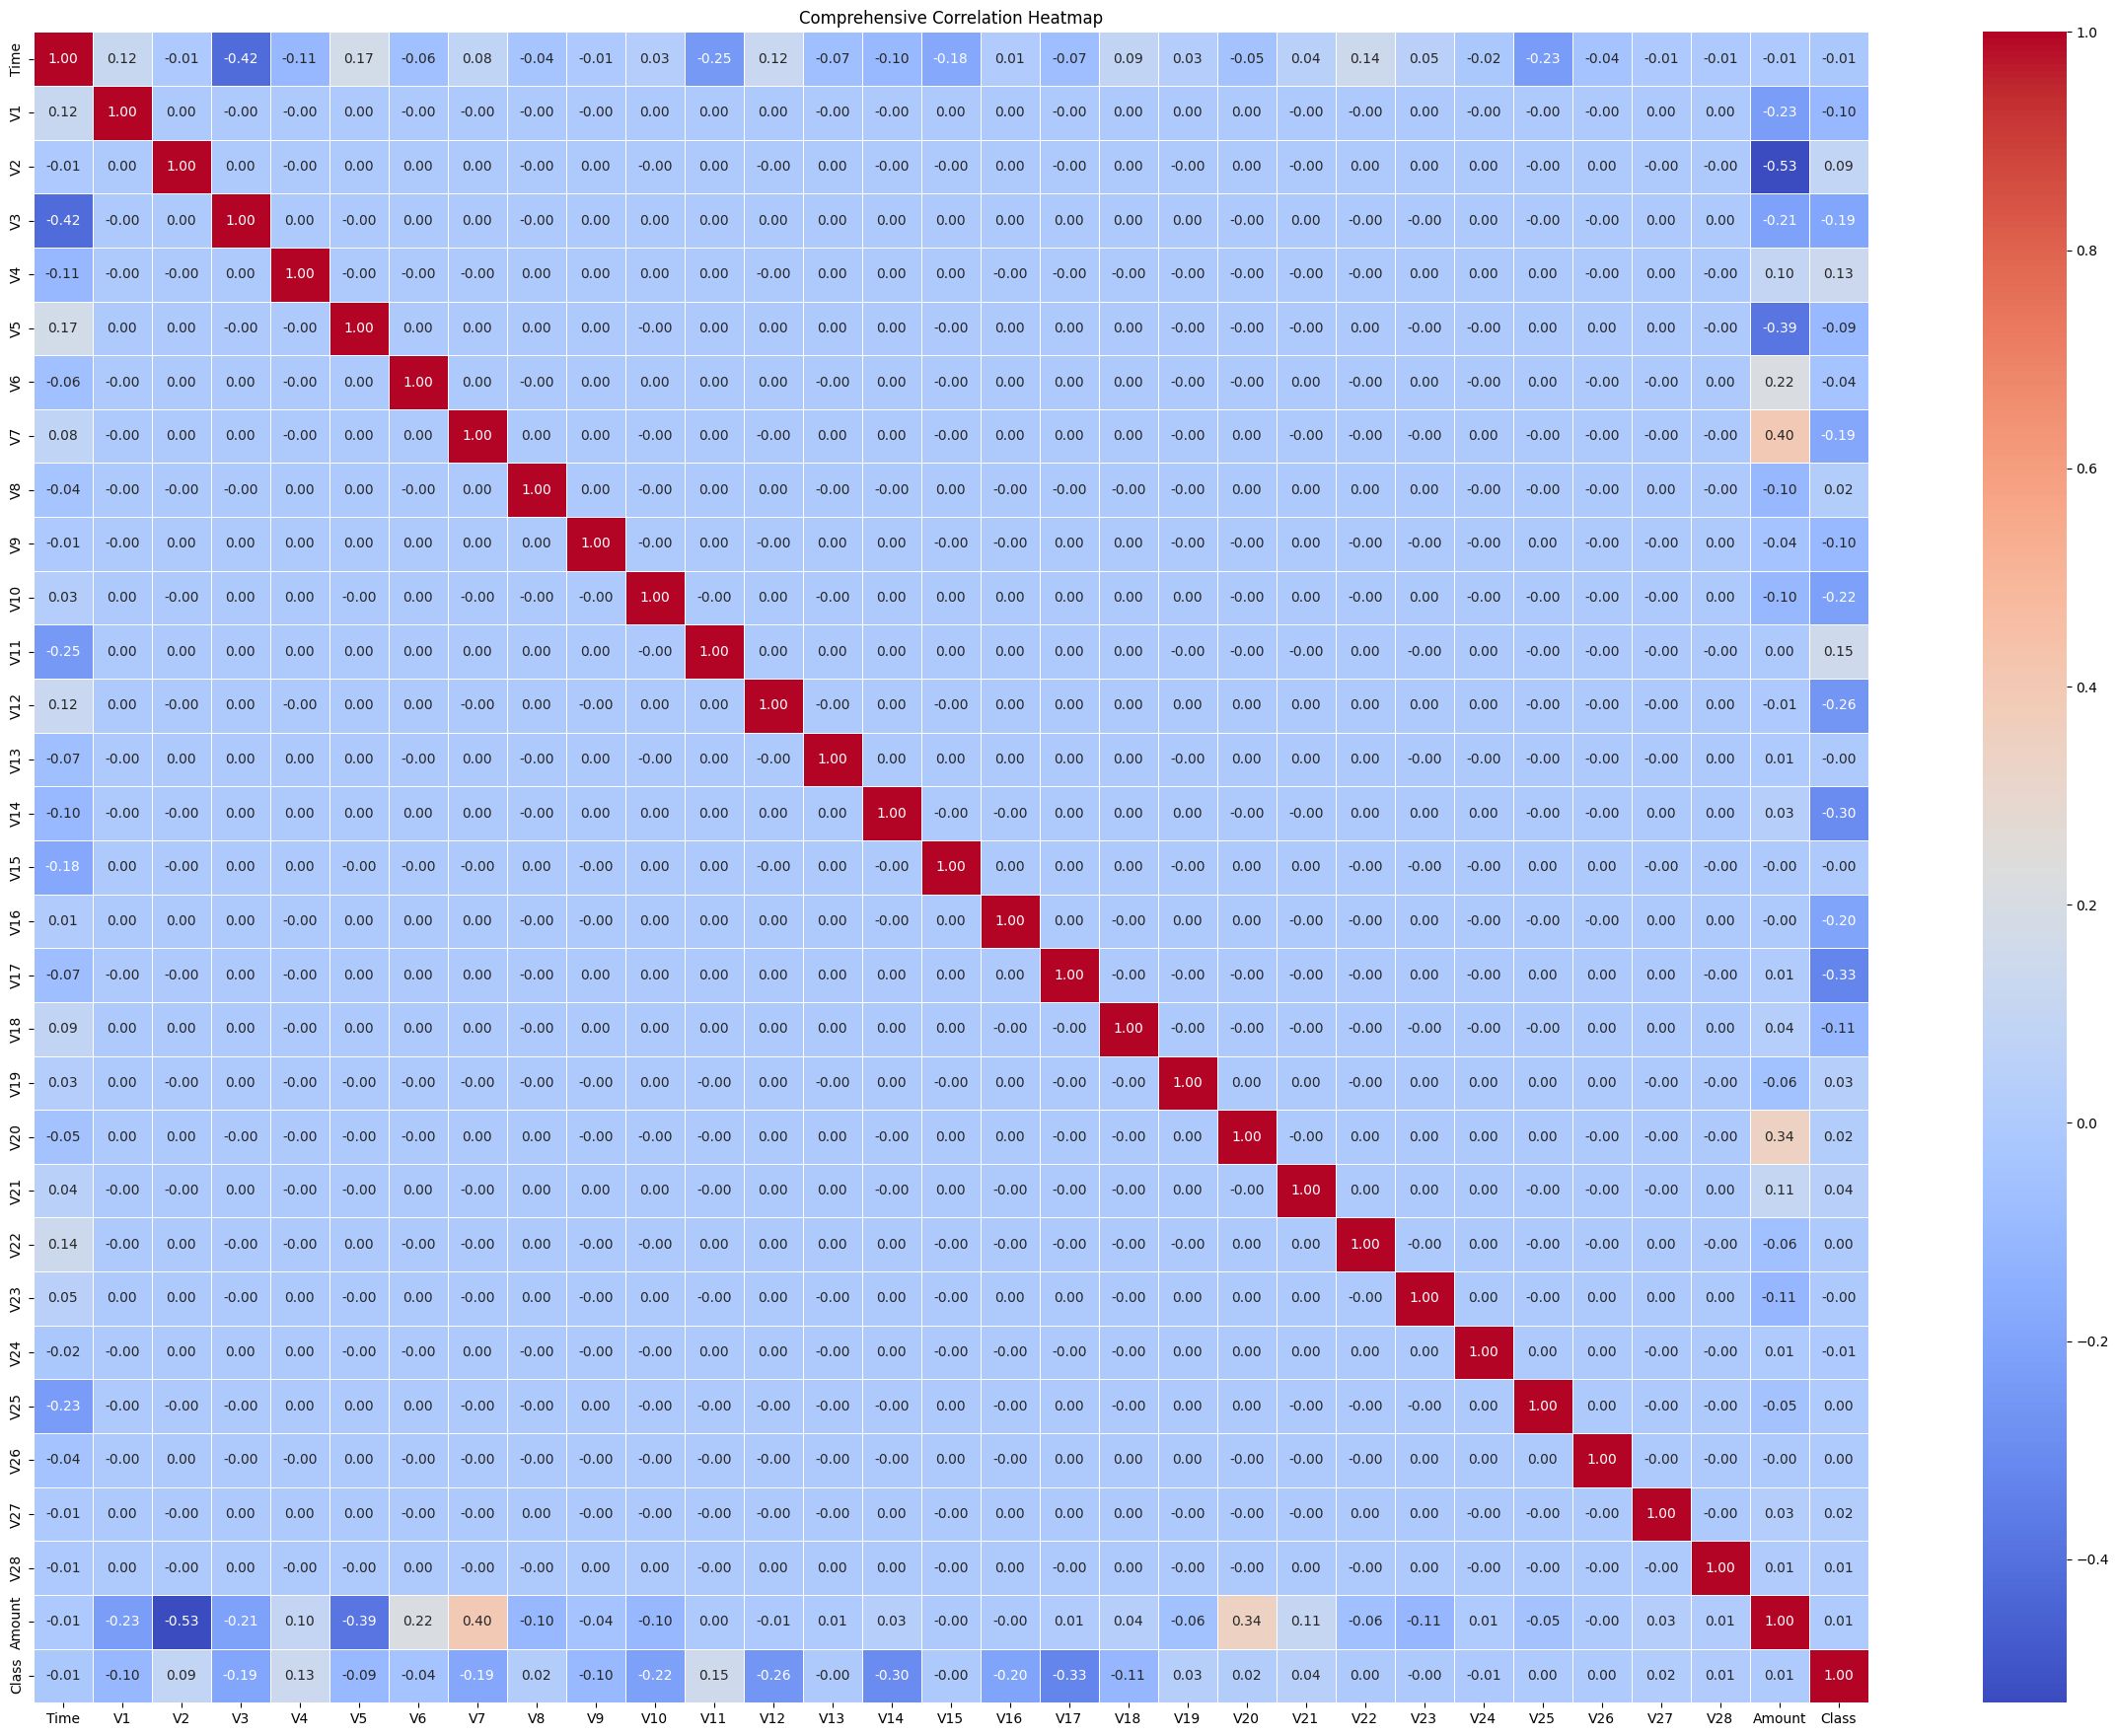

In [15]:
# Generating and displaying the initial comprehensive correlation heatmap:
import matplotlib.pyplot as plt
# Correlation matrix
correlation_matrix = credit_dataframe.corr()

# Creating a heatmap for better visualization
plt.figure(figsize=(30, 22))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Comprehensive Correlation Heatmap')
plt.show()


# Visualizing the distribution of fraudulent and non-fraudulent transactions using a bar plot

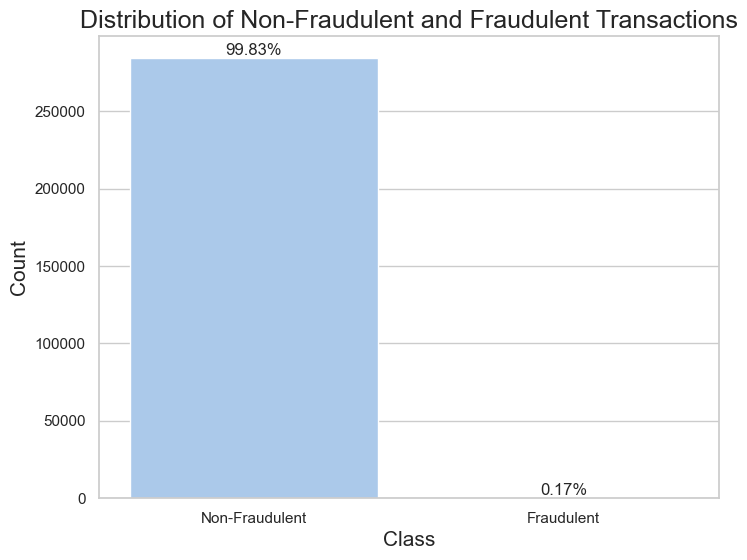

In [16]:
# Visualizing the distribution of Non-Fraudulent and Fraudulent transactions using a bar plot

plt.figure(figsize=(8, 6))

# Creating a more informative and visually appealing bar plot with labeled classes
sns.set(style="whitegrid")
class_counts = credit_dataframe['Class'].value_counts()
class_percentage = class_counts / len(credit_dataframe) * 100

# Renaming classes for better clarity
class_counts.index = ['Non-Fraudulent', 'Fraudulent']
class_percentage.index = ['Non-Fraudulent', 'Fraudulent']

bar_plot = sns.barplot(x=class_counts.index, y=class_counts, palette="pastel")

# Annotating with percentage values
for index, value in enumerate(class_counts):
    bar_plot.text(index, value + 20, f'{class_percentage[index]:.2f}%', ha='center', va='bottom', fontsize=12)

plt.title("Distribution of Non-Fraudulent and Fraudulent Transactions", fontsize=18)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()


## Observations:

1. The dataset is highly imbalanced, with a vast majority of transactions (99.83%) labeled as Non-Fraudulent.
2. In contrast, a very small percentage (0.17%) of the dataset corresponds to transactions labeled as Fraudulent.
3. The imbalance in class distribution may pose challenges for machine learning models, as they might be biased towards predicting the majority class (Non-Fraudulent) and could potentially overlook the minority class (Fraudulent).
4. Addressing the class imbalance through techniques like resampling, data augmentation, or employing specialized algorithms may be necessary to improve the model's ability to detect Fraudulent transactions effectively.
5. It is crucial to consider appropriate evaluation metrics, such as precision, recall, and F1-score, rather than solely relying on accuracy, given the imbalanced nature of the dataset.

In [17]:
# Generate a scatter plot to visualize the class distribution over time
# Given the time is in a relative format, utilizing pandas.Timedelta to represent the duration between two dates or times.

# Convert 'Time' to Timedelta for precise time representation
delta_time = pd.to_timedelta(credit_dataframe['Time'], unit='s')

# Create additional columns for days, hours, and minutes
credit_dataframe['Time_Day'] = delta_time.dt.components.days.astype(int)
credit_dataframe['Time_Hour'] = delta_time.dt.components.hours.astype(int)
credit_dataframe['Time_Min'] = delta_time.dt.components.minutes.astype(int)


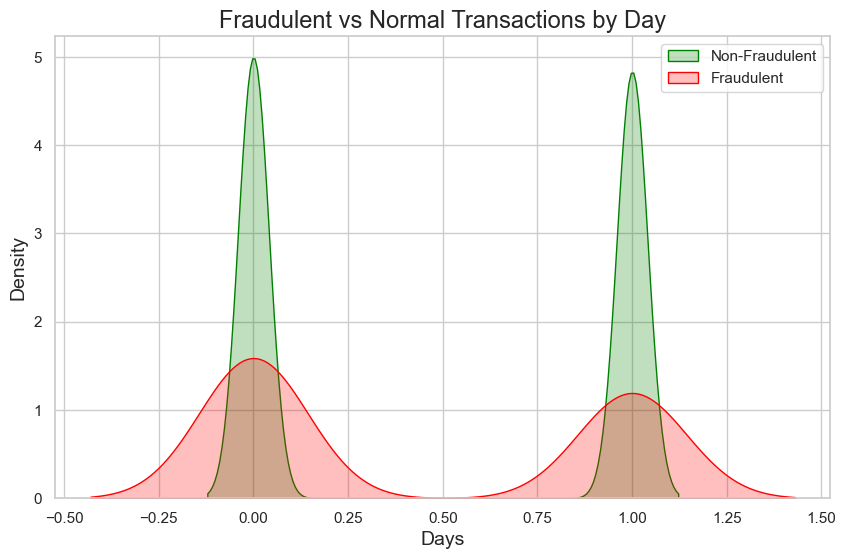

In [18]:
# Visualize Fraudulent vs Normal Transactions over Days using a Kernel Density Estimate (KDE) plot

plt.figure(figsize=(10, 6))

# KDE plot for Non-Fraudulent transactions (Class 0) in green
sns.kdeplot(credit_dataframe[credit_dataframe['Class'] == 0]["Time_Day"], color='green', label='Non-Fraudulent', fill=True)

# KDE plot for Fraudulent transactions (Class 1) in red
sns.kdeplot(credit_dataframe[credit_dataframe['Class'] == 1]["Time_Day"], color='red', label='Fraudulent', fill=True)

plt.title('Fraudulent vs Normal Transactions by Day', fontsize=17)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()


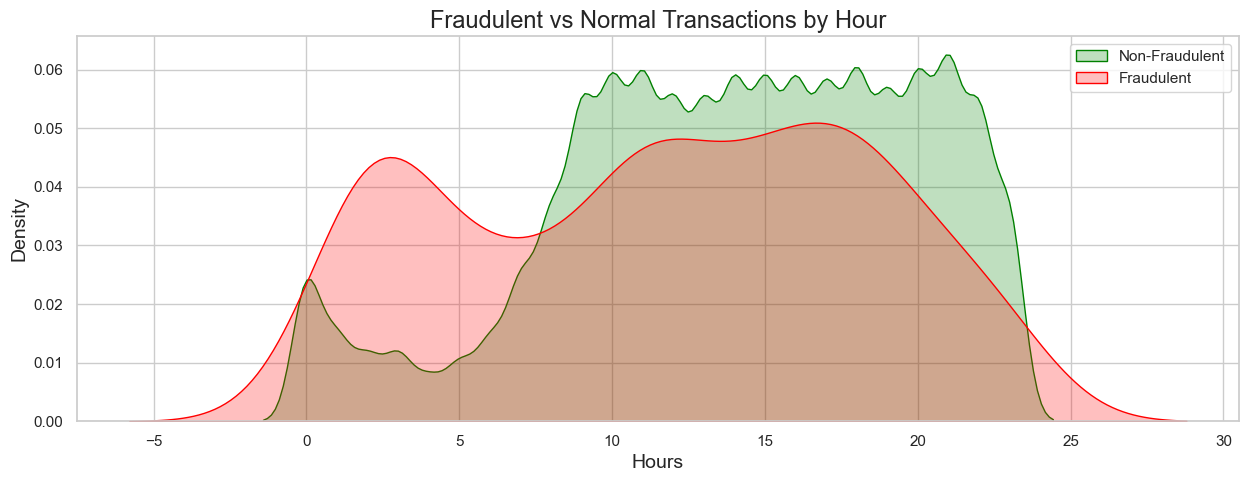

In [19]:
# Visualize Fraudulent vs Normal Transactions over Hours using a Kernel Density Estimate (KDE) plot

plt.figure(figsize=(15, 5))

# KDE plot for Non-Fraudulent transactions (Class 0) in green
sns.kdeplot(credit_dataframe[credit_dataframe['Class'] == 0]["Time_Hour"], color='green', label='Non-Fraudulent', fill=True)

# KDE plot for Fraudulent transactions (Class 1) in red
sns.kdeplot(credit_dataframe[credit_dataframe['Class'] == 1]["Time_Hour"], color='red', label='Fraudulent', fill=True)

plt.title('Fraudulent vs Normal Transactions by Hour', fontsize=17)
plt.xlabel('Hours', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()


Text(0.5, 1.05, 'Distribution of Classes over Time')

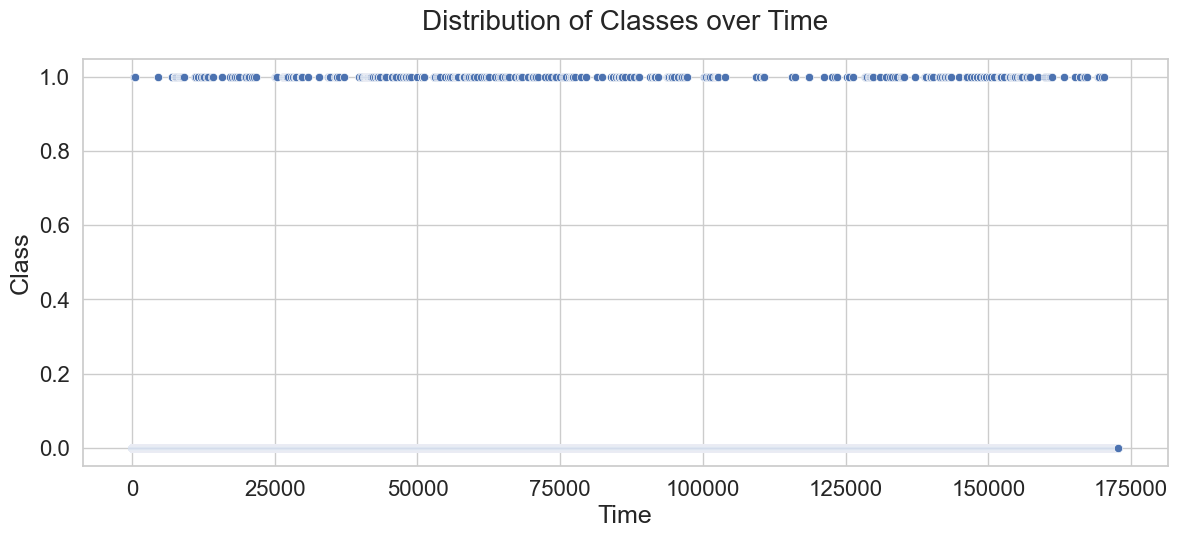

In [20]:
# Bivariate Analysis: Generate a scatter plot to explore the distribution of classes over time

# Set up the figure for better visualization
fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set2')

# Subplot 1: Scatter plot depicting the relationship between time and class
plt.subplot(3, 1, 1)
sns.scatterplot(x=credit_dataframe['Time'], y='Class', palette=cmap, data=credit_dataframe)
plt.xlabel('Time', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Distribution of Classes over Time', size=20, y=1.05)


Text(0.5, 1.05, 'Distribution of Classes with Respect to Amount')

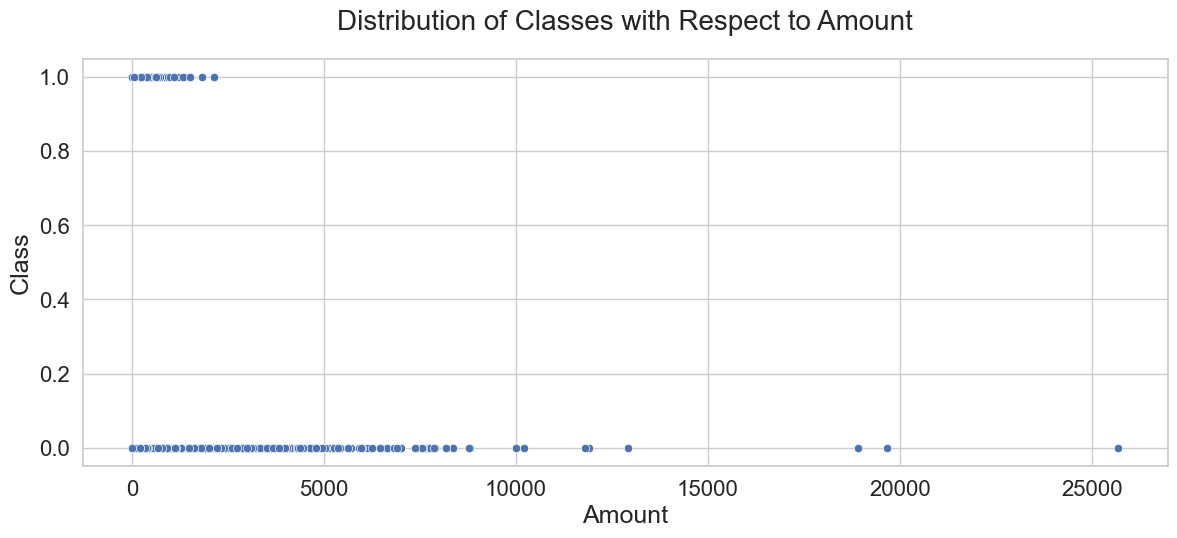

In [21]:
# Create a scatter plot to explore the distribution of classes in relation to transaction Amount

# Bivariate Analysis: Generate a scatter plot to observe the distribution of classes with Amount

fig = plt.figure(figsize=(14, 18))
cmap = sns.color_palette('Set1')

# Plotting the relationship between the variables:

plt.subplot(3, 1, 1)
sns.scatterplot(x=credit_dataframe['Amount'], y='Class', palette=cmap, data=credit_dataframe)
plt.xlabel('Amount', size=18)
plt.ylabel('Class', size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16) 
plt.title('Distribution of Classes with Respect to Amount', size=20, y=1.05)


In [22]:
# Exploring the correlation with the target variable 'Class' to identify important features:

print("Top features correlated with the target variable 'Class'")

# Calculate the correlation with the target variable
correlation_with_class = credit_dataframe.corr()['Class']

# Convert the series to a DataFrame for sorting
corr_df = pd.DataFrame(correlation_with_class)

# Rename the column from SalePrice to Correlation
corr_df.columns = ["Correlation"]

# Sort the correlations in descending order
sorted_corr_df = corr_df.sort_values(by=['Correlation'], ascending=False)

# Display the top 5 correlated features
sorted_corr_df.head(5)


Top features correlated with the target variable 'Class'


Correlation
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413

# Visualizing the Top Correlated Features:

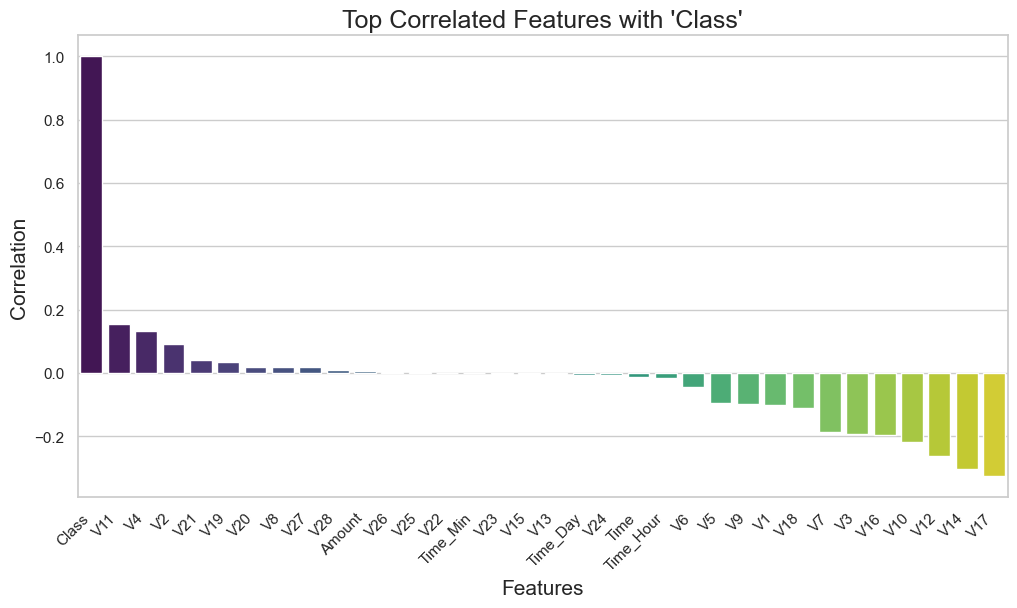

In [23]:
# Visualizing the top correlated features using a bar plot

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_corr_df.index, y='Correlation', data=sorted_corr_df, palette="viridis")
plt.title("Top Correlated Features with 'Class'", fontsize=18)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xticks(rotation=45, ha="right")
plt.show()


In [24]:
# Eliminate redundant columns
# Since we have extracted Day, Hour, and Minutes from the Time column, we can discard the original Time column.
credit_dataframe.drop('Time', axis=1, inplace=True)
# Considering this is not time series data, we may find Day and Minutes less informative; hence, retaining only the derived Hour column.
credit_dataframe.drop(['Time_Day', 'Time_Min'], axis=1, inplace=True)


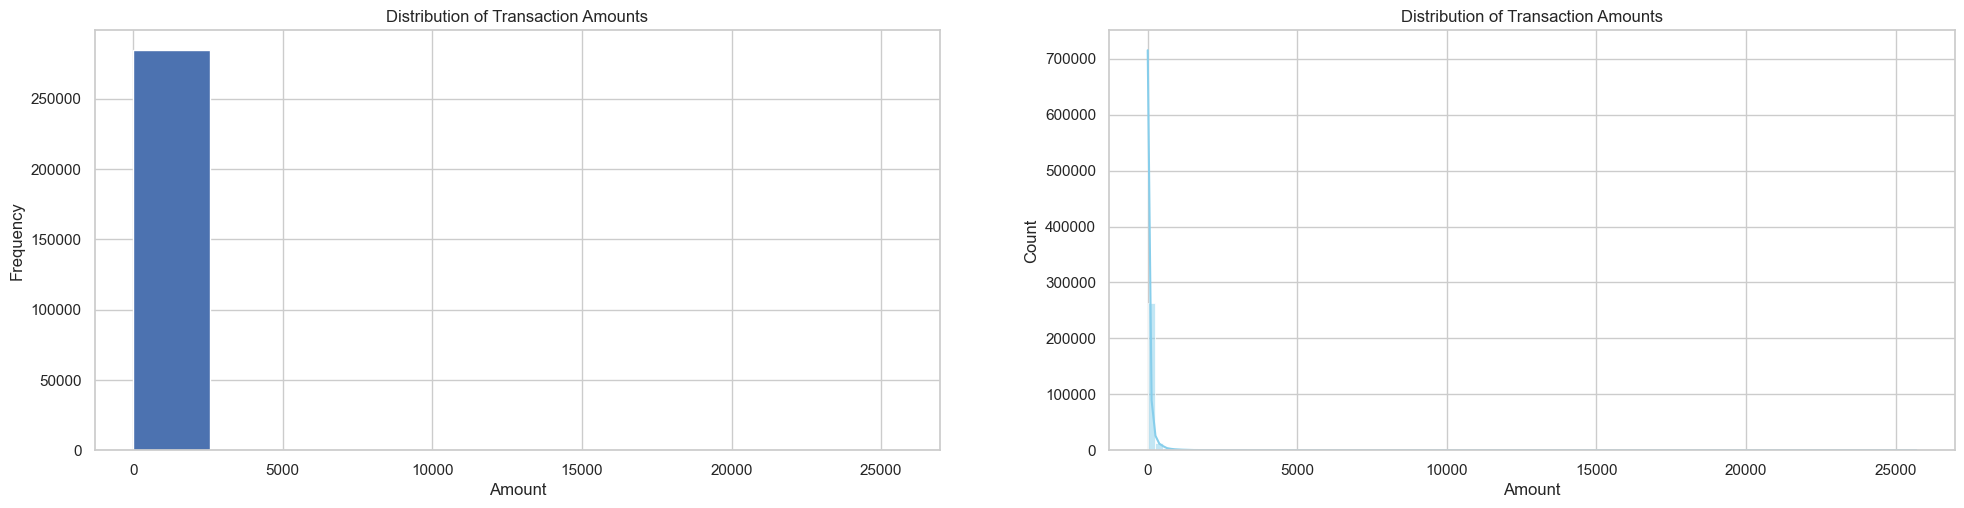

In [25]:
# Exploring the non-PCA transformed variable 'Amount' for insights:

plt.figure(figsize=(24, 12))

# Subplot 1: Histogram to visualize the distribution of Amount
plt.subplot(2, 2, 1)
plt.title('Distribution of Transaction Amounts')
credit_dataframe['Amount'].astype(int).plot.hist()
plt.xlabel("Amount")

# Subplot 2: Enhanced Histogram using Seaborn
plt.subplot(2, 2, 2)
plt.title('Distribution of Transaction Amounts')
sns.histplot(credit_dataframe['Amount'], bins=100, kde=True, color='skyblue')
plt.xlabel("Amount")
plt.show()


# Train & test data Split

In [26]:
# Generating datasets for independent (X) and dependent (y) variables

# Dependent variable (Target)
y = credit_dataframe['Class']
print(y.shape)
# Independent variables
X = credit_dataframe.drop(['Class'], axis=1)
print(X.shape)

(284807,)
(284807, 30)


In [27]:
X.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Time_Hour  
0  0.128539 -0.189115  0.133558 -0.021053  149.62          0  
1  0.167170  0.125895 -0.008983  0.014724    2.69          0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66          0  
3  0.647376 -0.221929  0.062723  0.061458  123.50          0  
4 -0.206010  0.502292  0.219422  0.215153   69.99          0  

[5 rows x 30 columns]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(227845, 30)
(56962, 30)
(227845,)
(56962,)


## Create a DataFrame to store model evaluation results

In [30]:

results_df = pd.DataFrame(columns=['Data_Imbalance_Handling', 'Model', 'Accuracy', 'ROC_Value', 'Threshold'])


### Handling Skewed Distributions:
- Utilize the <b>Power Transformer</b> package from the <b>preprocessing library in sklearn</b> to transform skewed distributions and achieve a more Gaussian-like distribution.


In [31]:
# Apply the PowerTransformer to fit and transform the training and test data
from sklearn.preprocessing import PowerTransformer

# Fit the PowerTransformer on the training data
pt = PowerTransformer()
pt.fit(X_train)

# Transform the training and test data
X_train_transformed = pt.transform(X_train)
X_test_transformed = pt.transform(X_test)


In [32]:
cols = list(X.columns.values)

In [33]:
#Create Dataframe
X_train_pt_df = pd.DataFrame(data=X_train_transformed,   columns=cols)
X_test_pt_df = pd.DataFrame(data=X_test_transformed,   columns=cols)

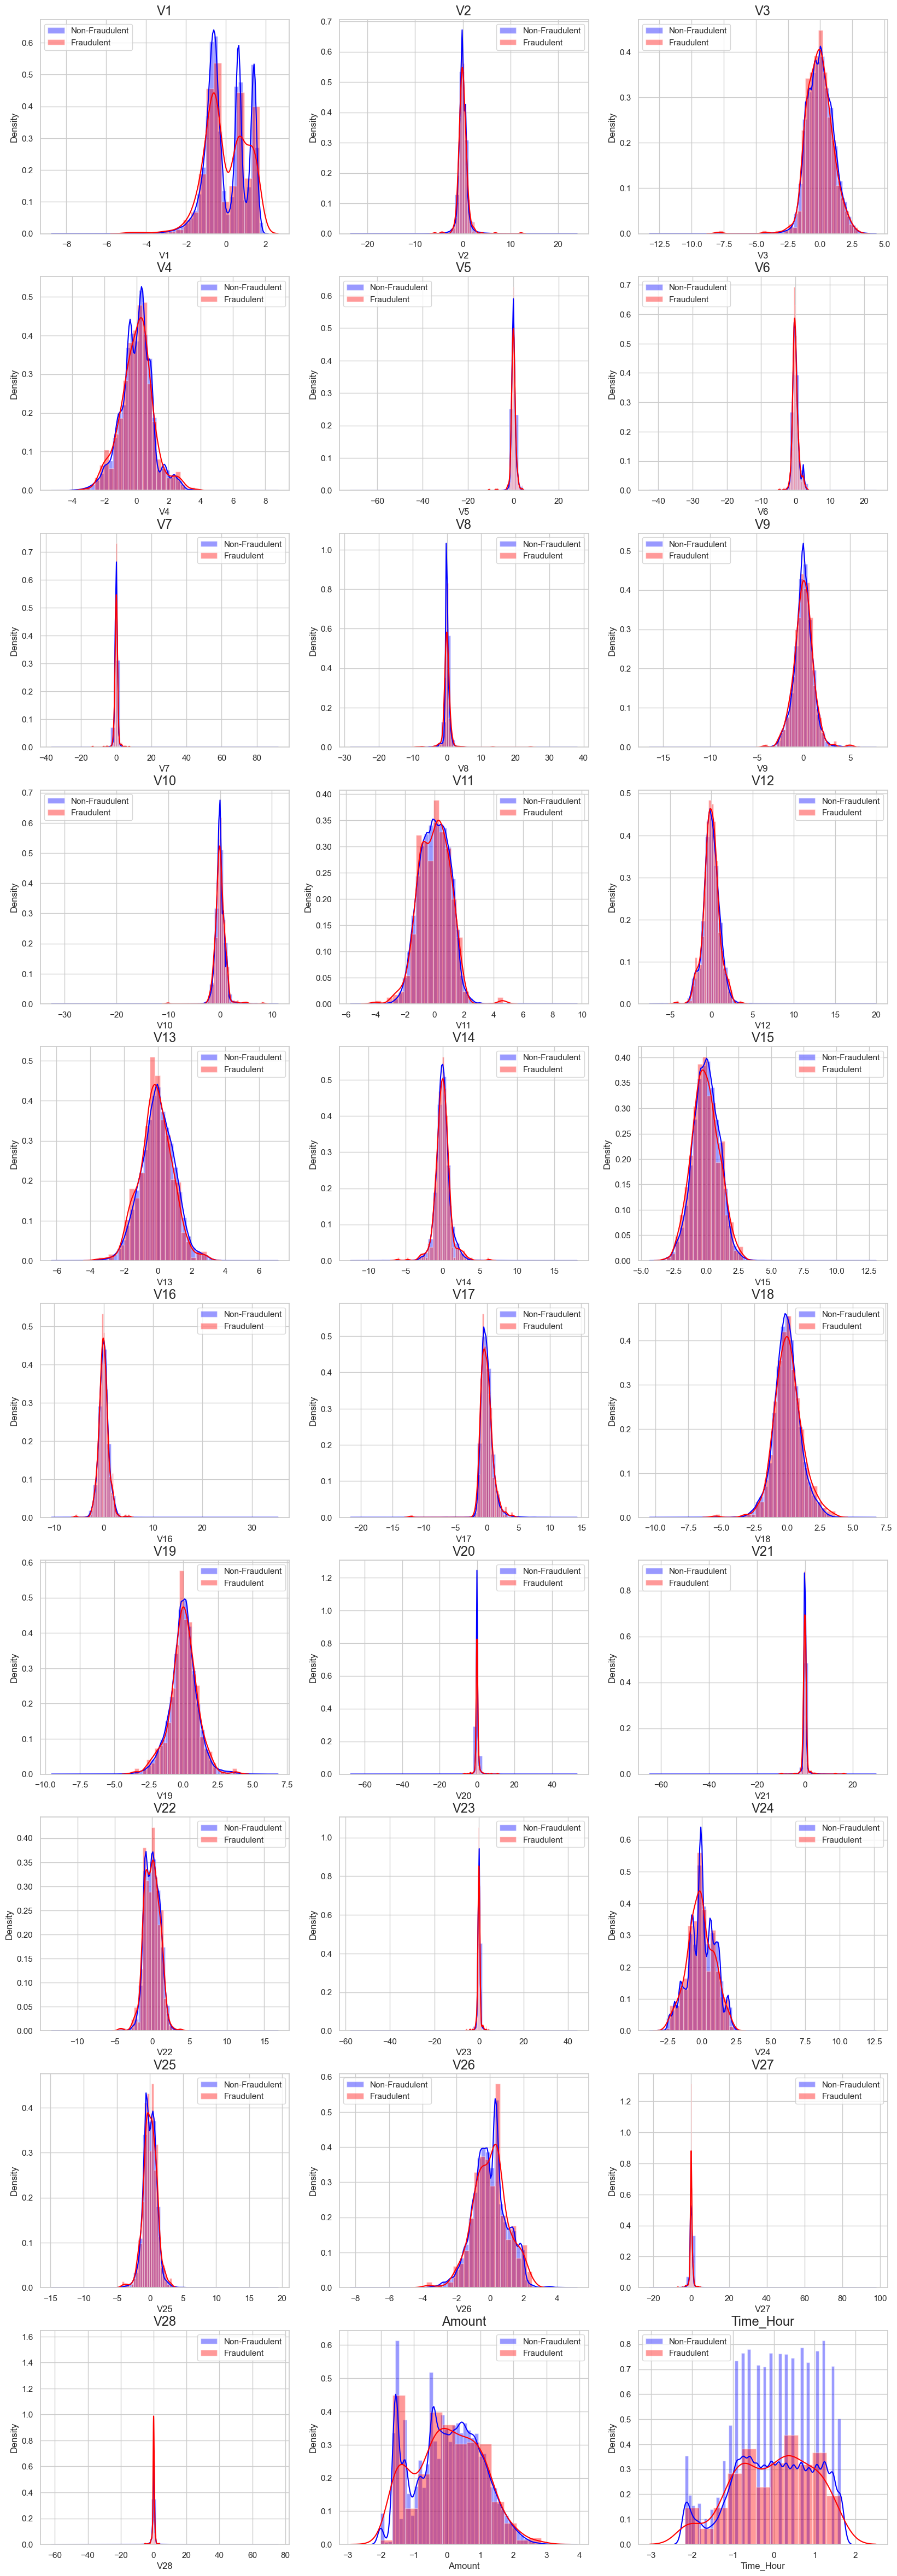

In [34]:
# Plot histograms of variables from the transformed training dataset to observe the results
non_fraudulent_records = credit_dataframe.Class == 0
fraud_records = credit_dataframe.Class == 1
plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
  plt.subplot(10, 3, n+1)
  sns.distplot(X_train_pt_df[col][non_fraudulent_records], color='blue', label='Non-Fraudulent')
  sns.distplot(X_train_pt_df[col][fraud_records], color='red', label='Fraudulent')
  plt.title(col, fontsize=17)
  plt.legend()
plt.show()


## Model Building
- Build different models on the imbalanced dataset and see the result

In [35]:
# Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handling','Model','Accuracy','ROC_Value','Threshold'])

Running Logistic Regression with L1 and L2 Regularization
Max auc_roc for l2: 0.5
Max auc_roc for l1: 0.9813863284665615
Parameters for l2 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

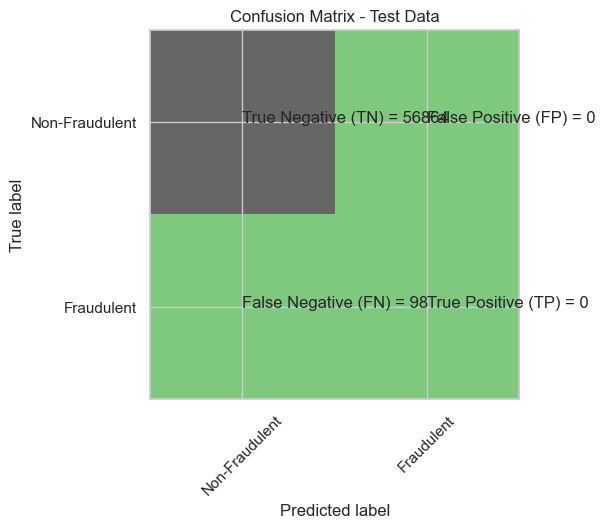

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Accuarcy of Logistic model with l1 regularisation : 0.9991397773954567
Confusion Matrix


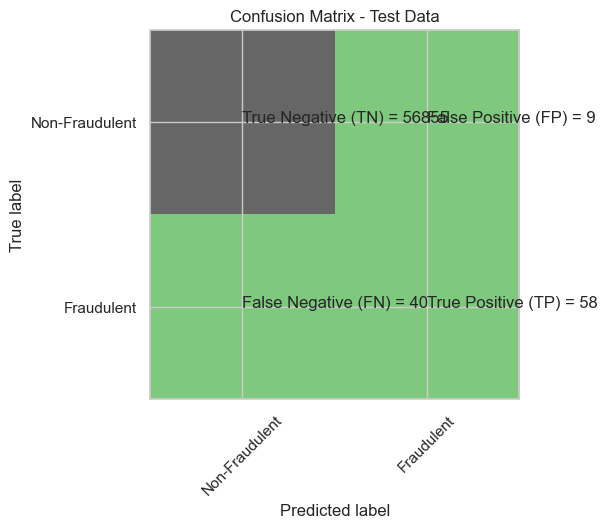

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.59      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.5
Threshold value inf
l2 threshold: inf
ROC for the test dataset 50.0%


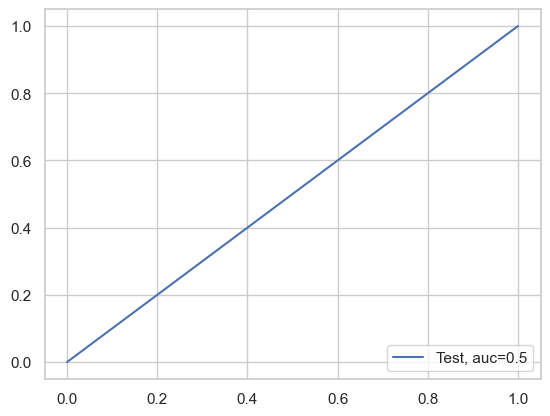

l1 roc_value: 0.9829810546897431
l1 threshold: 0.006689242762703675
ROC for the test dataset 98.3%


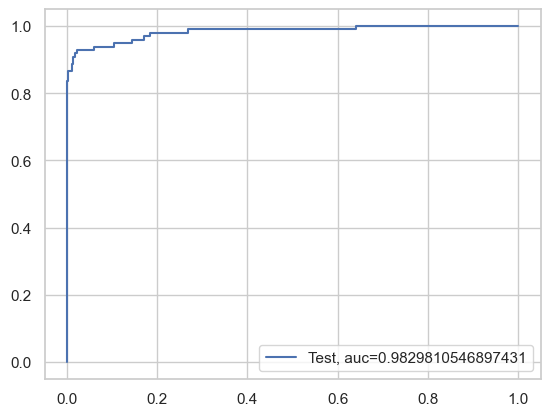

Time Taken by Model: --- 63.19650316238403 seconds ---
--------------------------------------------------------------------------------
Running KNN Model
Model Score: 0.9995259997893332
Confusion Matrix


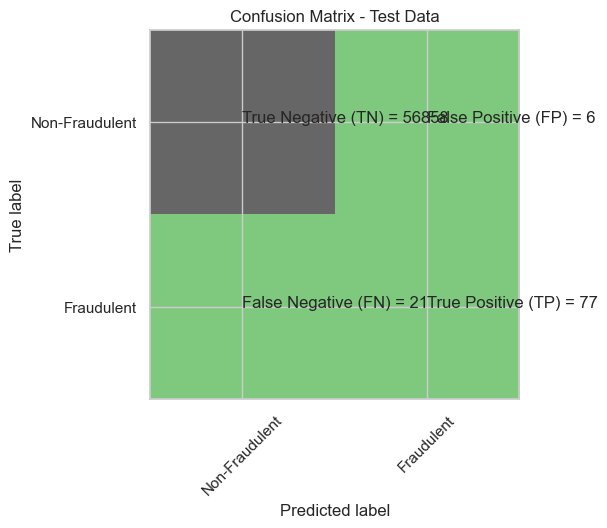

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.79      0.85        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

KNN ROC Value: 0.9284628630574345
KNN Threshold: 0.2
ROC for the Test Dataset 92.8%


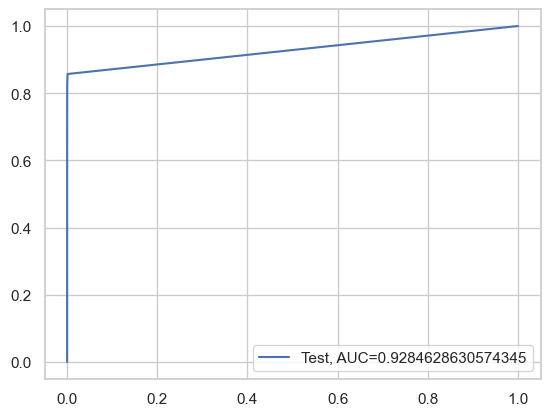

Time Taken by Model: --- 62.14233589172363 seconds ---
--------------------------------------------------------------------------------
Running Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.9990695551420246
Confusion Matrix


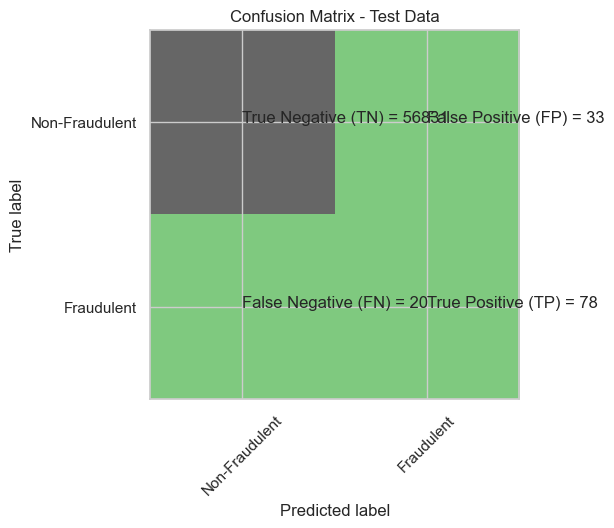

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.80      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Gini tree_roc_value: 0.89766901766334
Tree Threshold: 1.0
ROC for the Test Dataset 89.8%


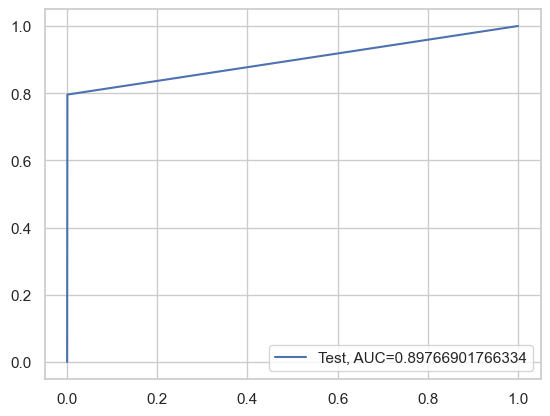

Entropy score: 0.9991573329588147
Confusion Matrix


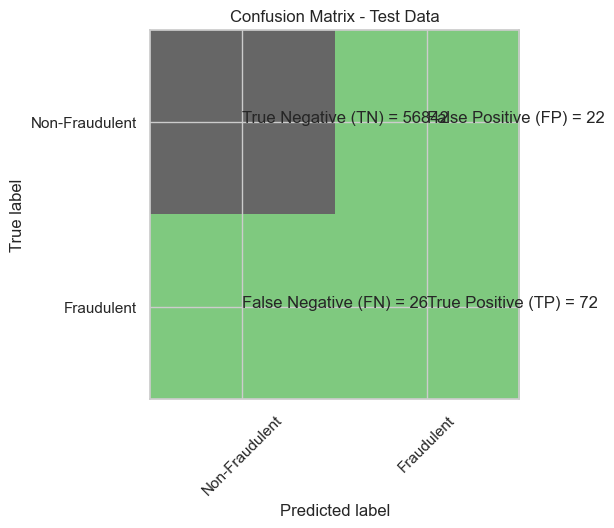

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.73      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Entropy tree_roc_value: 0.8671534947687572
Tree Threshold: 1.0
ROC for the Test Dataset 86.7%


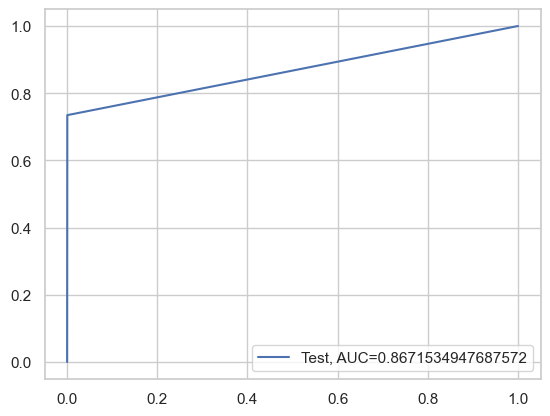

Time Taken by Model: --- 27.863070011138916 seconds ---
--------------------------------------------------------------------------------
Running Random Forest Model
Model Accuracy: 0.9995611109160493
Confusion Matrix


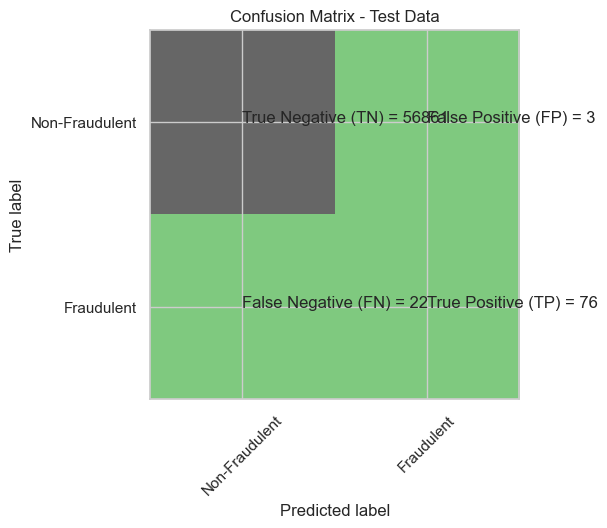

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest ROC Value: 0.962755658326921
Random Forest Threshold: 0.01
ROC for the Test Dataset 96.3%


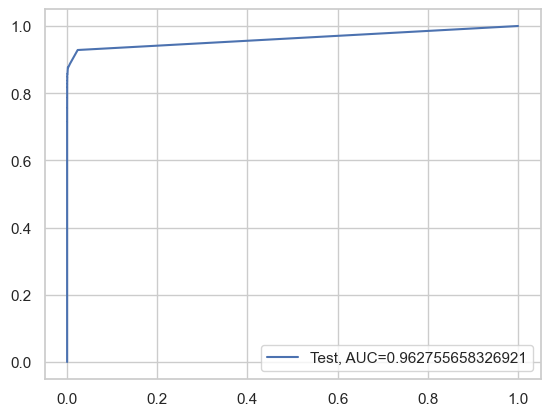

Time Taken by Model: --- 195.79164791107178 seconds ---
--------------------------------------------------------------------------------
Running XGBoost Model
Model Accuracy: 0.9995962220427653


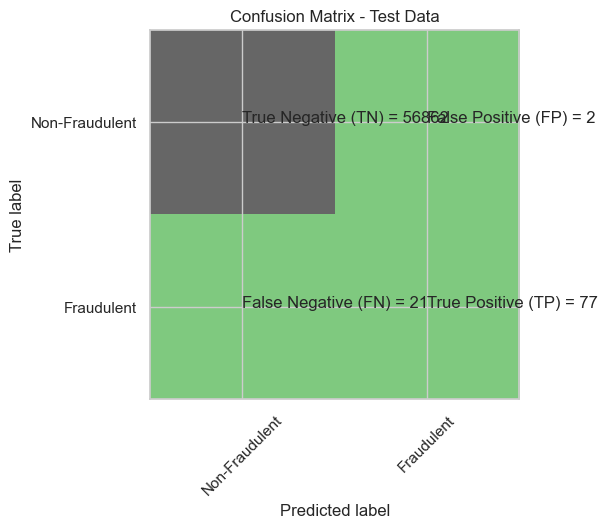

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost ROC Value: 0.9843638742779048
XGBoost Threshold: 6.946160283405334e-05
ROC for the Test Dataset 98.4%


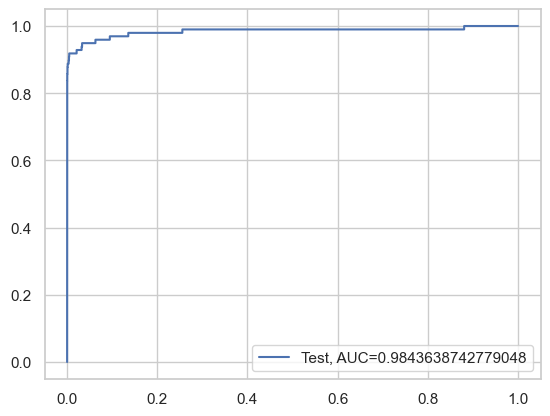

Time Taken by Model: --- 1.8988926410675049 seconds ---
--------------------------------------------------------------------------------
Running SVM Model with Sigmoid Kernel
Accuracy Score: 0.99875355500158
Confusion Matrix


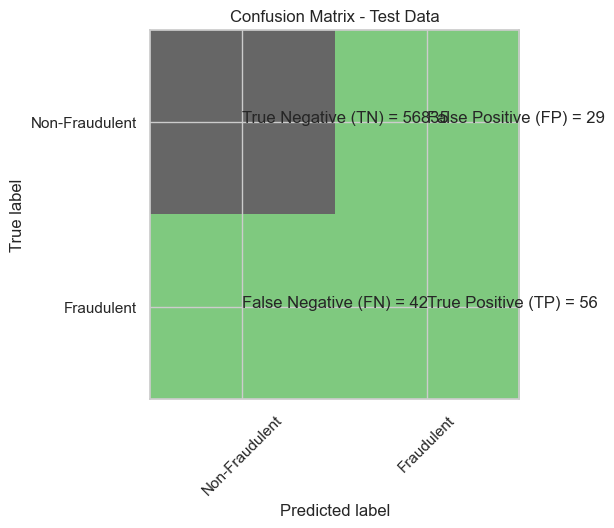

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.57      0.61        98

    accuracy                           1.00     56962
   macro avg       0.83      0.79      0.81     56962
weighted avg       1.00      1.00      1.00     56962

SVM ROC Value: 0.856416993499707
SVM Threshold: 0.00020053038886681053
ROC for the Test Dataset 85.6%


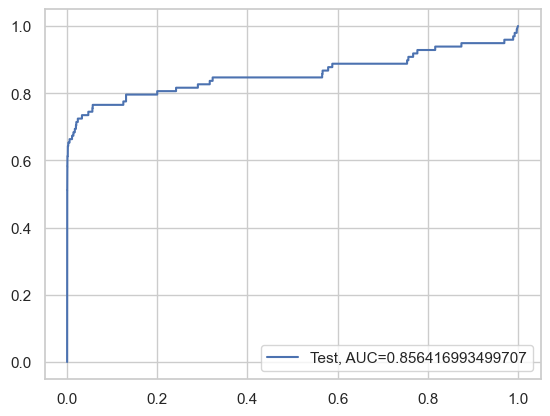

Time Taken by Model: --- 81.24777793884277 seconds ---


In [36]:
# Create a dataframe to store results
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handling','Model','Accuracy','ROC_Value','Threshold'])
# Execute logistic regression models with both L1 and L2 regularization
print("Running Logistic Regression with L1 and L2 Regularization")
start_time = time.time()
df_Results = LR_model(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80)

# Execute KNN model
print("Running KNN Model")
start_time = time.time()
df_Results = KNN_Model(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80)

# Execute Decision Tree models with 'gini' & 'entropy' criteria
print("Running Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_Results = DT_Model(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80)

# Execute Random Forest model
print("Running Random Forest Model")
start_time = time.time()
df_Results = RF_Model(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80)

# Execute XGBoost model
print("Running XGBoost Model")
start_time = time.time()
df_Results = XGBoost_Models(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80)

# Execute SVM model with Sigmoid Kernel
print("Running SVM Model with Sigmoid Kernel")
start_time = time.time()
aa = SVM_Model(df_Results, "Power Transformer", X_train_pt_df, y_train, X_test_pt_df, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))


In [37]:
df_Results

Data_Imbalance_Handling                                       Model  \
0       Power Transformer  Logistic Regression with L2 Regularisation   
1       Power Transformer  Logistic Regression with L1 Regularisation   
2       Power Transformer                                         KNN   
3       Power Transformer              Tree Model with Gini Criterion   
4       Power Transformer           Tree Model with Entropy Criterion   
5       Power Transformer                               Random Forest   
6       Power Transformer                                     XGBoost   

   Accuracy  ROC_Value  Threshold  
0  0.998280   0.500000        inf  
1  0.999140   0.982981   0.006689  
2  0.999526   0.928463   0.200000  
3  0.999070   0.897669   1.000000  
4  0.999157   0.867153   1.000000  
5  0.999561   0.962756   0.010000  
6  0.999596   0.984364   0.000069

# Perform cross validation with RepeatedKFold

In [38]:
from sklearn.model_selection import RepeatedKFold

# Define the Repeated K-Fold Cross-Validator
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

# X represents the feature set, and y represents the target
for train_index, test_index in rkf.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.5703880472042273
Max auc_roc for l1: 0.9714817171579508
Parameters for l2 regularisations
[[-1.16349374e-07  9.61730067e-08 -1.71062515e-07  1.02160471e-07
  -7.88863328e-08 -2.02361016e-08 -1.48220362e-07  1.81975002e-08
  -7.14003597e-08 -1.46663412e-07  1.00429581e-07 -1.52568884e-07
  -9.22506246e-09 -1.89861043e-07 -2.88426688e-09 -1.09275604e-07
  -1.70119688e-07 -6.09028231e-08  2.69834241e-08  1.10705590e-08
   1.72351472e-08 -6.62682547e-09 -5.57000057e-10 -4.02615562e-09
  -6.69257717e-10  1.40818467e-10  6.13115015e-09  2.82323506e-09
  -6.59976467e-04 -1.04894081e-04]]
[-7.46582641e-06]
{1: array([[0.54781313, 0.54798666, 0.54750887, 0.54667128, 0.54667128,
        0.54667128, 0.54667128, 0.54667128, 0.54667128, 0.54667128,
        0.54667128, 0.54667128, 0.54667128, 0.54667128, 0.54667128,
        0.54667128, 0.54667128, 0.54667128, 0.54667128, 0.54667128],
       [0.52362705, 0.52293985, 0.52125115, 0

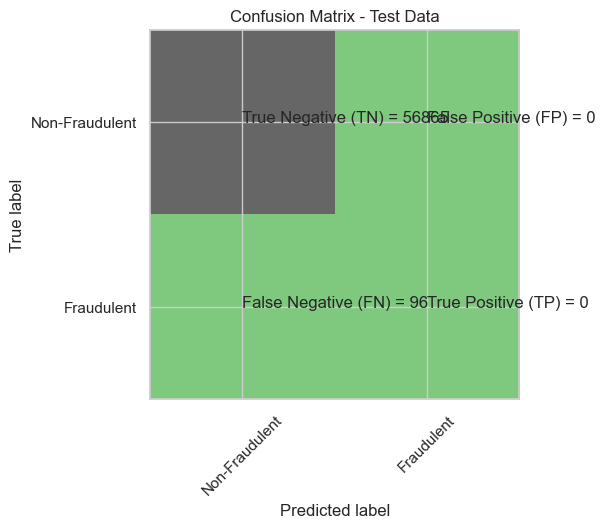

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.00      0.00      0.00        96

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9991222064219378
Confusion Matrix


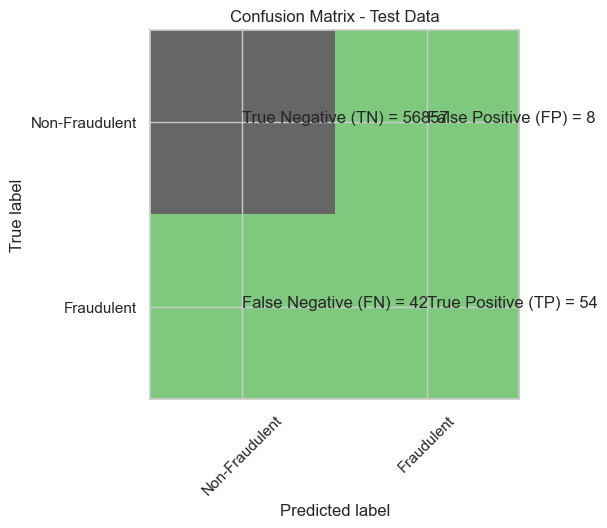

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.87      0.56      0.68        96

    accuracy                           1.00     56961
   macro avg       0.94      0.78      0.84     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.5461434611213692
Threshold value 0.4993636285777457
l2 threshold: 0.4993636285777457
ROC for the test dataset 54.6%


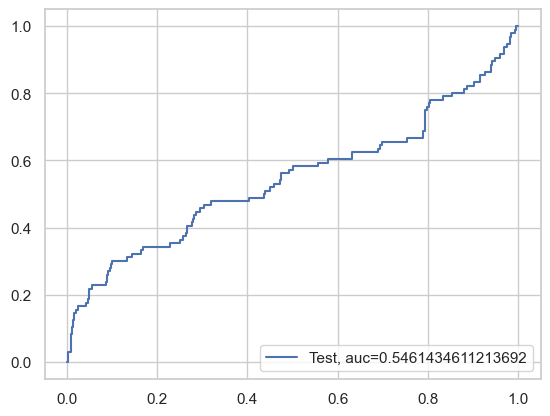

l1 roc_value: 0.8968710615785926
l1 threshold: 0.04932983016313672
ROC for the test dataset 89.7%


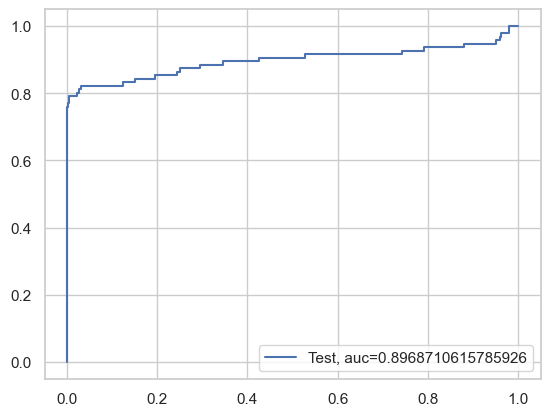

Time Taken by Model: --- 62.610060930252075 seconds ---
Gini score: 0.9991924299081828
Confusion Matrix


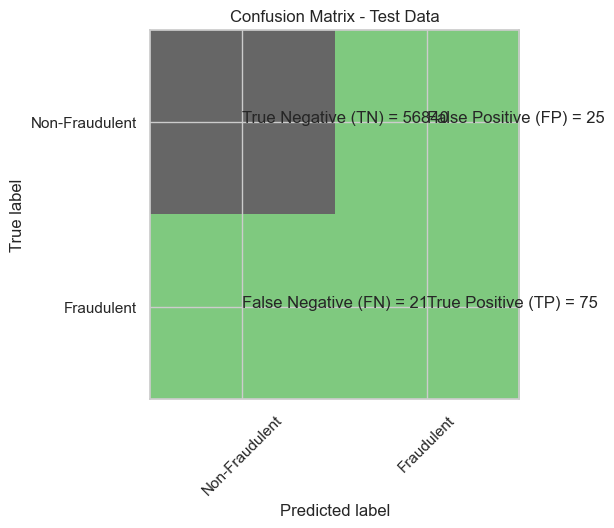

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.75      0.78      0.77        96

    accuracy                           1.00     56961
   macro avg       0.87      0.89      0.88     56961
weighted avg       1.00      1.00      1.00     56961

Gini tree_roc_value: 0.8904051811307483
Tree Threshold: 1.0
ROC for the Test Dataset 89.0%


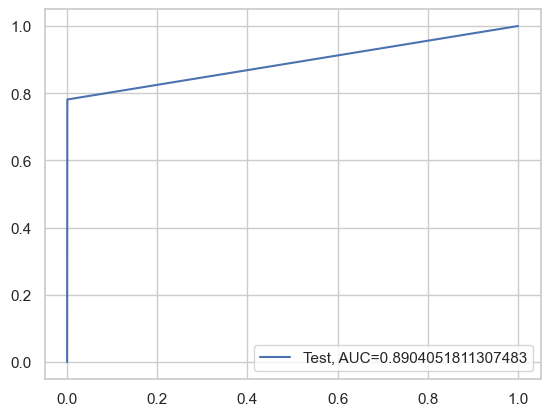

Entropy score: 0.9992099857797441
Confusion Matrix


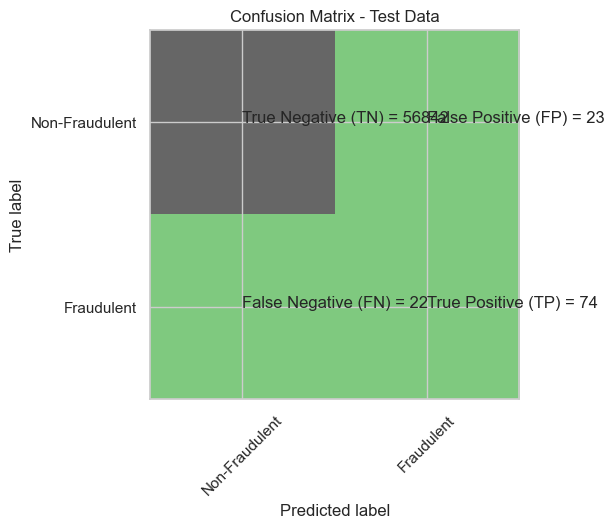

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.76      0.77      0.77        96

    accuracy                           1.00     56961
   macro avg       0.88      0.89      0.88     56961
weighted avg       1.00      1.00      1.00     56961

Entropy tree_roc_value: 0.8852144333069553
Tree Threshold: 1.0
ROC for the Test Dataset 88.5%


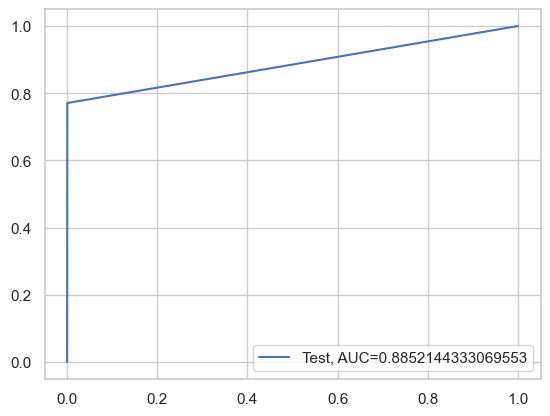

Time Taken by Model: --- 26.074908018112183 seconds ---
--------------------------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9996137708256526
Confusion Matrix


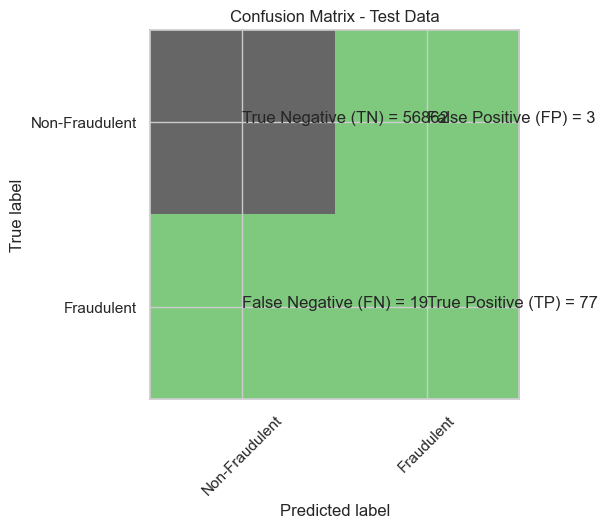

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.96      0.80      0.88        96

    accuracy                           1.00     56961
   macro avg       0.98      0.90      0.94     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest ROC Value: 0.9412097181922096
Random Forest Threshold: 0.02
ROC for the Test Dataset 94.1%


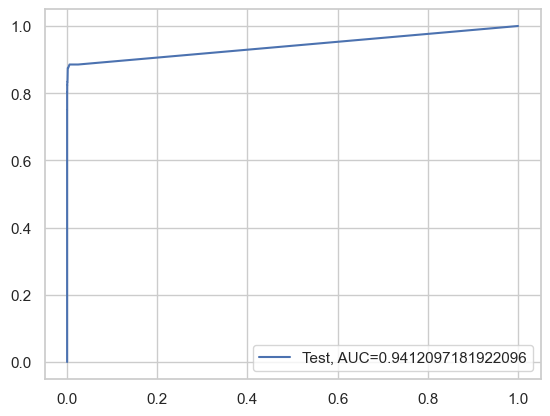

Time Taken by Model: --- 187.61400604248047 seconds ---
--------------------------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9995962149540913


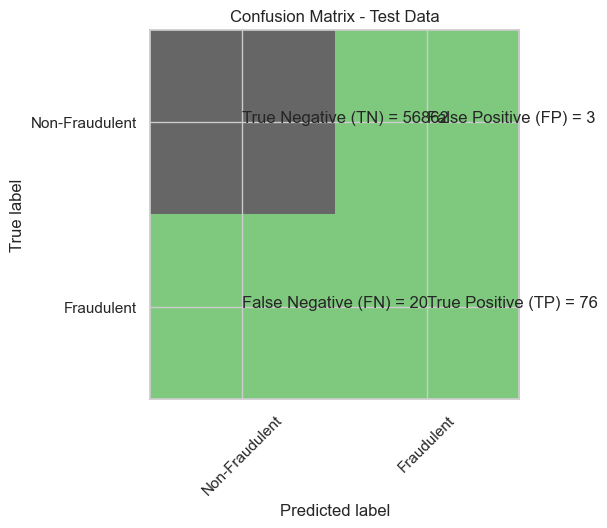

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.96      0.79      0.87        96

    accuracy                           1.00     56961
   macro avg       0.98      0.90      0.93     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost ROC Value: 0.9870143834813447
XGBoost Threshold: 6.483924516942352e-05
ROC for the Test Dataset 98.7%


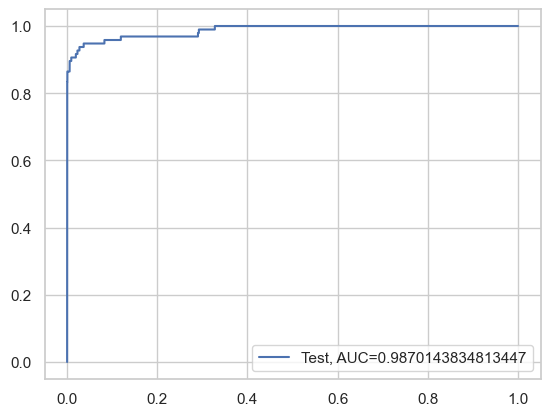

Time Taken by Model: --- 1.9016761779785156 seconds ---
--------------------------------------------------------------------------------
SVM Model with Sigmoid Kernel
Accuracy Score: 0.9984550833026106
Confusion Matrix


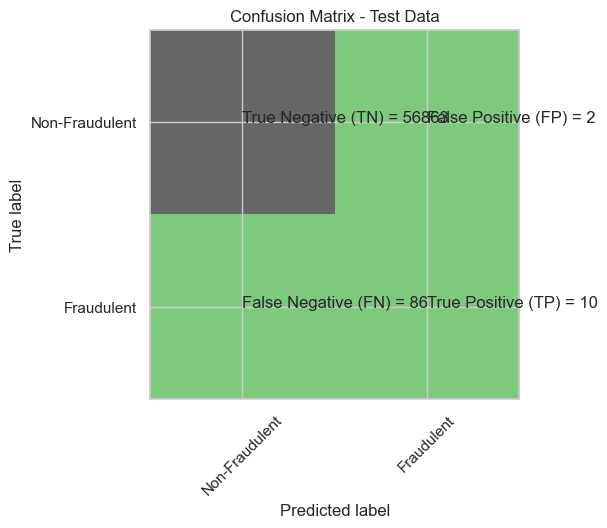

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56865
           1       0.83      0.10      0.19        96

    accuracy                           1.00     56961
   macro avg       0.92      0.55      0.59     56961
weighted avg       1.00      1.00      1.00     56961

SVM ROC Value: 0.49427921392772356
SVM Threshold: 0.0029489384107295466
ROC for the Test Dataset 49.4%


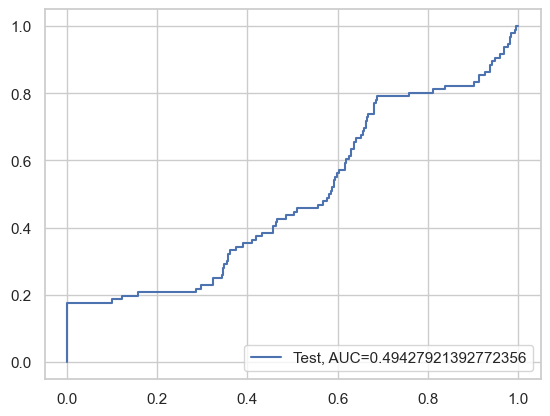

Time Taken by Model: --- 761.4532949924469 seconds ---


In [39]:
#Run Logistic Regression with L1 And L2 Regularisation
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_Results = LR_model(df_Results,"RepeatedKFold Cross Validation", X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
df_Results = DT_Model(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run Random Forest Model
print("Random Forest Model")
start_time = time.time()
df_Results = RF_Model(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run XGBoost Modela
print("XGBoost Model")
start_time = time.time()
df_Results = XGBoost_Models(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-'*80 )
#Run SVM Model with Sigmoid Kernel
print("SVM Model with Sigmoid Kernel")
start_time = time.time()
df_Results = SVM_Model(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [40]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

## Observations
-It appears that employing XGBoost with Repeated K-Fold cross-validation has yielded the most favorable outcomes, achieving an ROC value of 0.9830.

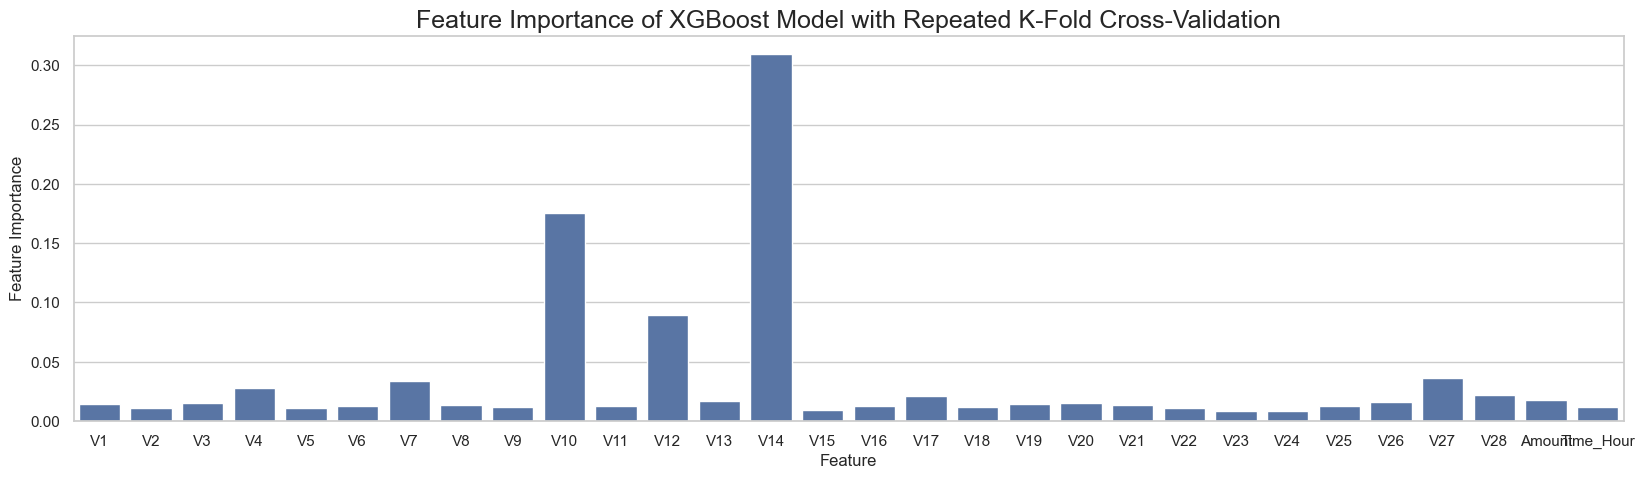

In [41]:
# Import XGBoost Classifier
from xgboost import XGBClassifier

# Instantiate XGBoost Classifier
XGBmodel = XGBClassifier(random_state=42)

# Fit the model to the training data
XGBmodel.fit(X_train_cv, y_train_cv)

# Extract feature importances
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(XGBmodel.feature_importances_))], axis=1)
coefficients.columns = ['Feature', 'Feature Importance']

# Plot feature importances
plt.figure(figsize=(20, 5))
sns.barplot(x='Feature', y='Feature Importance', data=coefficients)
plt.title("Feature Importance of XGBoost Model with Repeated K-Fold Cross-Validation", fontsize=18)
plt.show()


# Conduct cross-validation using Stratified K-Fold

In [42]:
# Importing necessary libraries
from sklearn.model_selection import StratifiedKFold

# Instantiating Stratified K-Fold Cross-Validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

# X represents the feature set and y represents the target
for train_index, test_index in skf.split(X, y):
    # Splitting the data into training and testing sets
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]

In [43]:
print(X_test_skf.shape, y_test_skf.shape)

(56961, 30) (56961,)


Running Logistic Regression with L1 And L2 Regularization
Max auc_roc for l2: 0.5505399157793633
Max auc_roc for l1: 0.9761385141201387
Parameters for l2 regularisations
[[-1.59426976e-07  7.83287756e-08 -1.86741729e-07  1.26308193e-07
  -9.30233018e-08 -2.92528693e-08 -1.61397270e-07  1.49153396e-09
  -5.73503913e-08 -1.55476506e-07  1.01136023e-07 -1.58872693e-07
  -7.50196270e-09 -1.87797521e-07  1.26981442e-08 -1.15106062e-07
  -1.77256505e-07 -5.20063962e-08  1.32252635e-08  3.75829651e-09
   1.79459217e-08  1.28789326e-09 -3.91730895e-09 -3.41533225e-09
   4.05723362e-10  2.70731933e-09  7.98828671e-09  4.21827291e-09
  -6.68939430e-04 -1.06865043e-04]]
[-7.60608373e-06]
{1: array([[0.50463848, 0.50420593, 0.50265363, 0.49971061, 0.49971061,
        0.49971061, 0.49971061, 0.49971061, 0.49971061, 0.49971061,
        0.49971061, 0.49971061, 0.49971061, 0.49971061, 0.49971061,
        0.49971061, 0.49971061, 0.49971061, 0.49971061, 0.49971061],
       [0.54798264, 0.54682875, 0.544

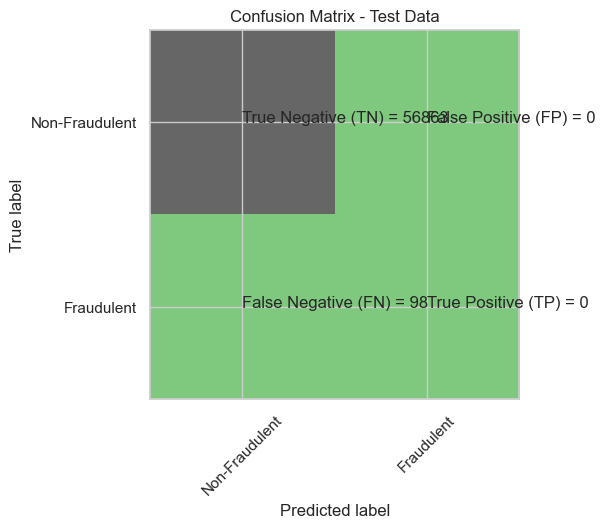

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9990695388072541
Confusion Matrix


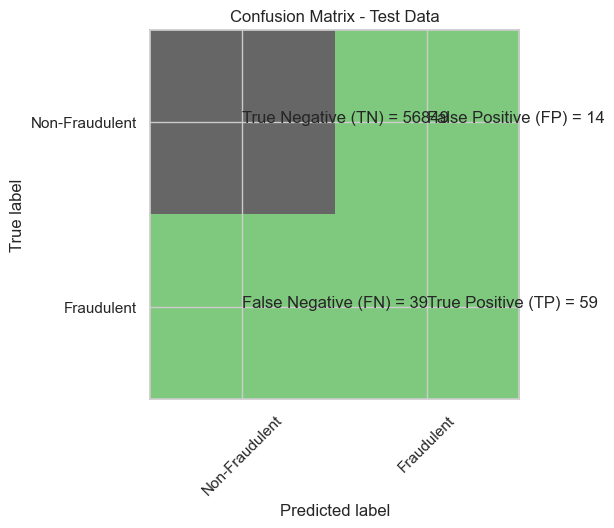

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.60      0.69        98

    accuracy                           1.00     56961
   macro avg       0.90      0.80      0.84     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.613287324672584
Threshold value 0.4991824190911876
l2 threshold: 0.4991824190911876
ROC for the test dataset 61.3%


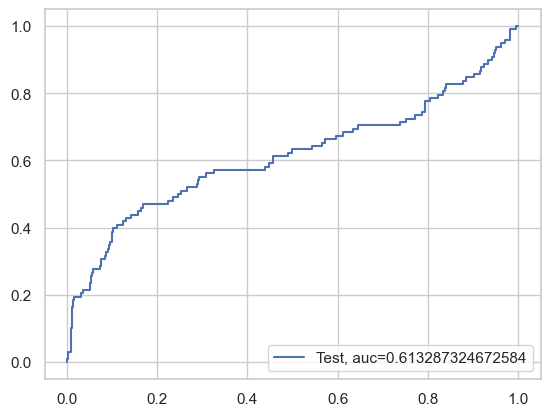

l1 roc_value: 0.8922279004280608
l1 threshold: 0.04926773563176117
ROC for the test dataset 89.2%


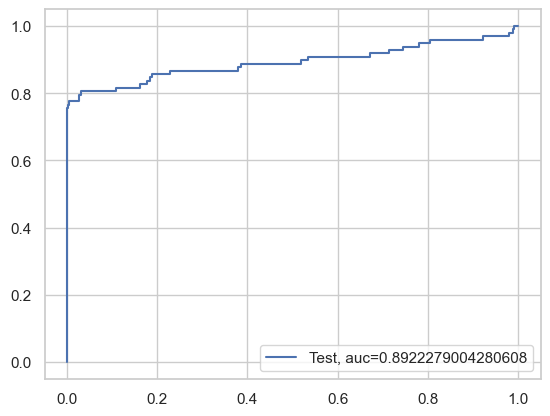

Time Taken by Model: --- 62.738085985183716 seconds ---
--------------------------------------------------------------------------------
Running Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.9991046505503766
Confusion Matrix


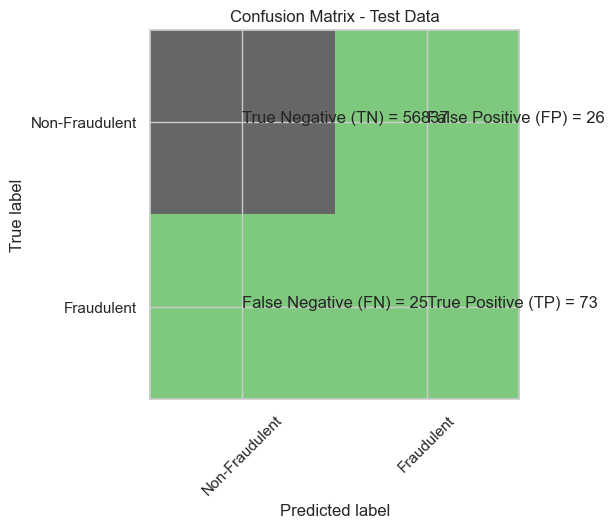

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.74      0.74        98

    accuracy                           1.00     56961
   macro avg       0.87      0.87      0.87     56961
weighted avg       1.00      1.00      1.00     56961

Gini tree_roc_value: 0.8722203599270283
Tree Threshold: 1.0
ROC for the Test Dataset 87.2%


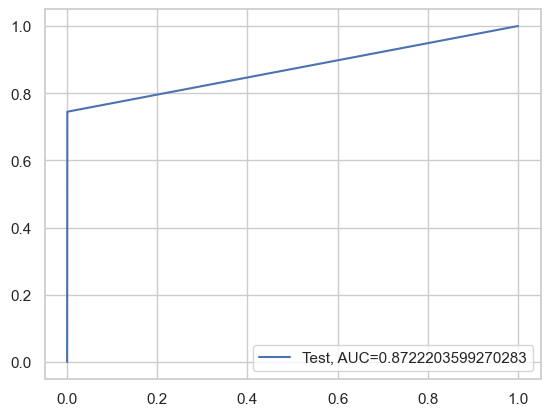

Entropy score: 0.9991046505503766
Confusion Matrix


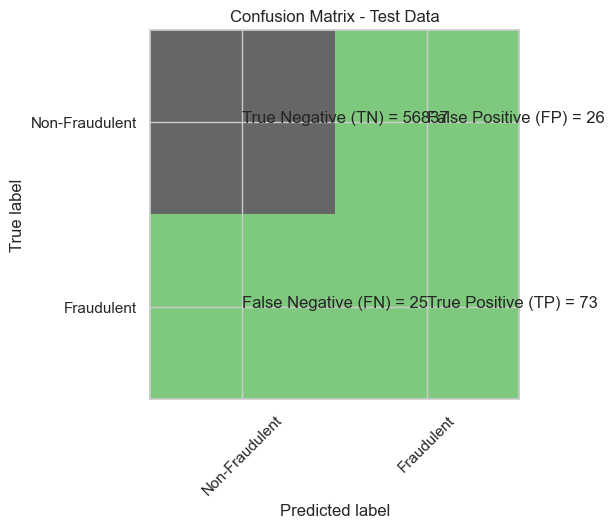

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.74      0.74        98

    accuracy                           1.00     56961
   macro avg       0.87      0.87      0.87     56961
weighted avg       1.00      1.00      1.00     56961

Entropy tree_roc_value: 0.8722203599270283
Tree Threshold: 1.0
ROC for the Test Dataset 87.2%


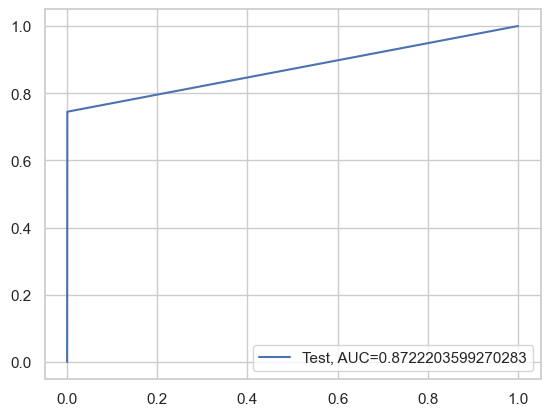

Time Taken by Model: --- 23.70120620727539 seconds ---
--------------------------------------------------------------------------------
Running Random Forest Model
Model Accuracy: 0.9994733238531627
Confusion Matrix


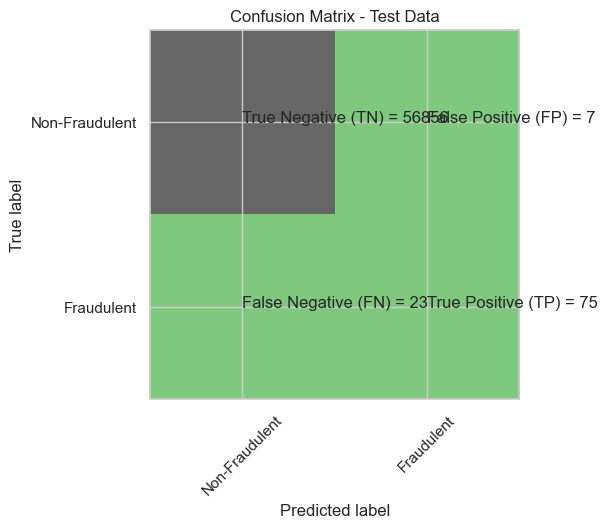

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.77      0.83        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest ROC Value: 0.9317079504013764
Random Forest Threshold: 0.01
ROC for the Test Dataset 93.2%


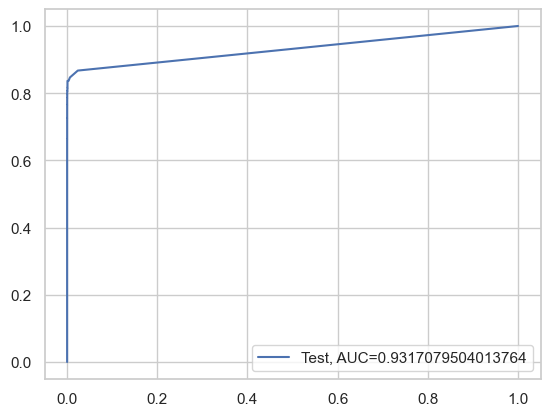

Time Taken by Model: --- 198.74701809883118 seconds ---
--------------------------------------------------------------------------------
Running XGBoost Model
Model Accuracy: 0.9994382121100402


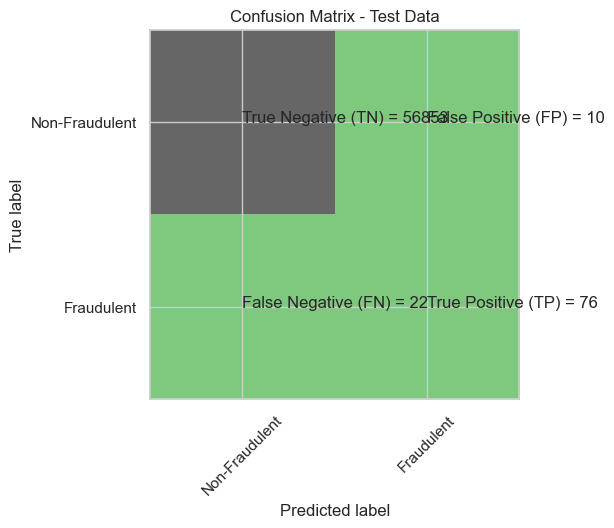

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.78      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost ROC Value: 0.955739125222922
XGBoost Threshold: 0.00023098787642084062
ROC for the Test Dataset 95.6%


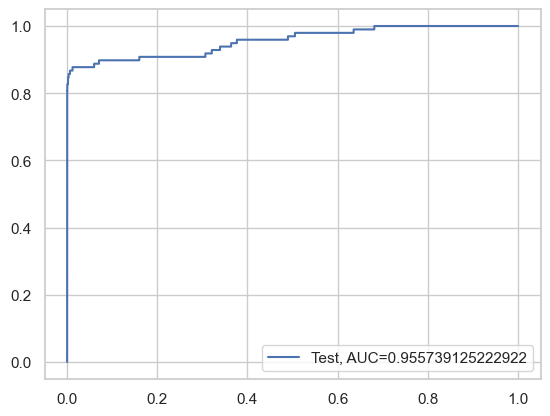

Time Taken by Model: --- 2.103342056274414 seconds ---
--------------------------------------------------------------------------------
Running SVM Model with Sigmoid Kernel
Accuracy Score: 0.9982444128438757
Confusion Matrix


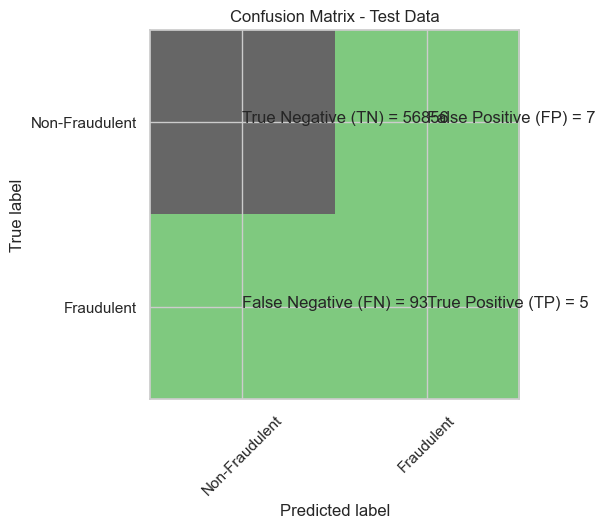

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.42      0.05      0.09        98

    accuracy                           1.00     56961
   macro avg       0.71      0.53      0.55     56961
weighted avg       1.00      1.00      1.00     56961

SVM ROC Value: 0.4559510560111001
SVM Threshold: 0.0028644541812495113
ROC for the Test Dataset 45.6%


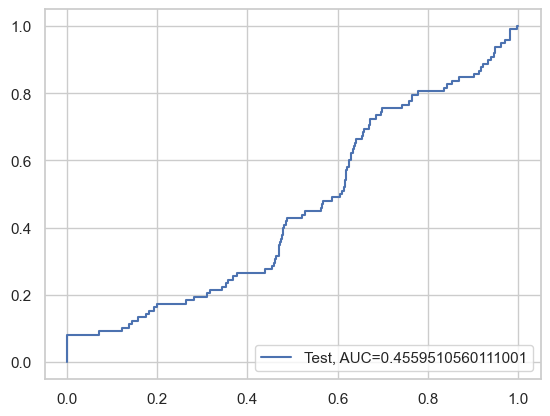

Time Taken by Model: --- 758.3779950141907 seconds ---


In [44]:
# Logistic Regression with L1 And L2 Regularization
print("Running Logistic Regression with L1 And L2 Regularization")
start_time = time.time()
df_results = LR_model(df_Results, "StratifiedKFold Cross Validation", X_train_skf, y_train_skf, X_test_skf, y_test_skf)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)


# Decision Tree Models with 'gini' & 'entropy' criteria
print("Running Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_results = DT_Model(df_Results, "StratifiedKFold Cross Validation", X_train_skf, y_train_skf, X_test_skf, y_test_skf)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Random Forest Model
print("Running Random Forest Model")
start_time = time.time()
df_results = RF_Model(df_Results, "StratifiedKFold Cross Validation", X_train_skf, y_train_skf, X_test_skf, y_test_skf)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# XGBoost Model
print("Running XGBoost Model")
start_time = time.time()
df_results = XGBoost_Models(df_Results, "StratifiedKFold Cross Validation", X_train_skf, y_train_skf, X_test_skf, y_test_skf)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# SVM Model with Sigmoid Kernel
print("Running SVM Model with Sigmoid Kernel")
start_time = time.time()
df_results = SVM_Model(df_Results, "StratifiedKFold Cross Validation", X_train_skf, y_train_skf, X_test_skf, y_test_skf)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))


In [45]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

**As the results show Logistic Regression with L2 Regularisation for StratifiedFold cross validation provided best results**



**Its is evident that V4, V11, v5 has + ve imporatnce whereas V14, V12, V10 seems to have -ve impact on the predictaions**

#As the models Oversampling data, take significantly longer time to run.
We will try with undersampling methods

In [46]:
# Undersampling Technique

from imblearn.under_sampling import RandomUnderSampler
# Instantiate RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5)
# Fit the sampler and apply the transformation
X_under, y_under = rus.fit_resample(X_train, y_train)
# Create DataFrame
X_under = pd.DataFrame(data=X_under, columns=cols)


Running Logistic Regression Models with L1 And L2 Regularization
Max auc_roc for l2: 0.5
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

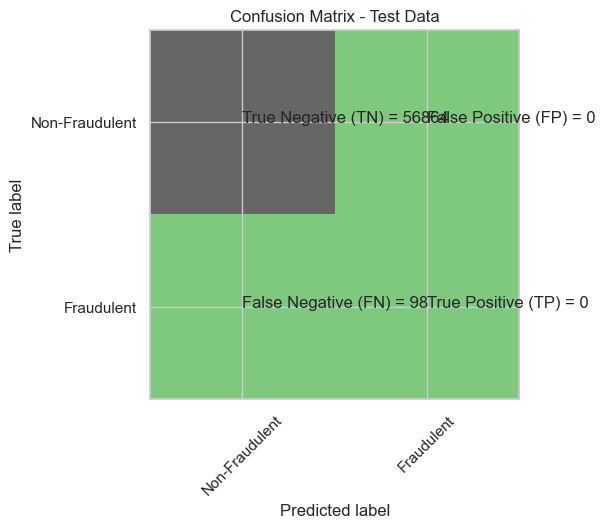

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Accuarcy of Logistic model with l1 regularisation : 0.9982795547909132
Confusion Matrix


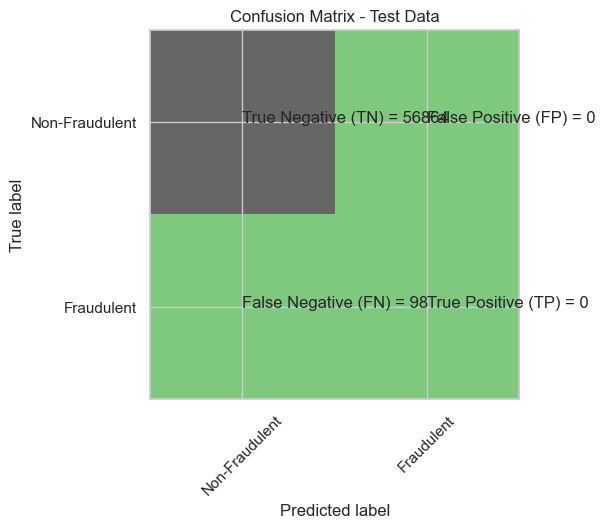

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

l2 roc_value: 0.5
Threshold value inf
l2 threshold: inf
ROC for the test dataset 50.0%


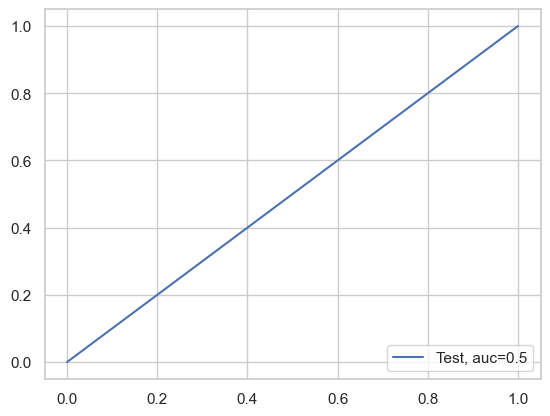

l1 roc_value: 0.5
l1 threshold: inf
ROC for the test dataset 50.0%


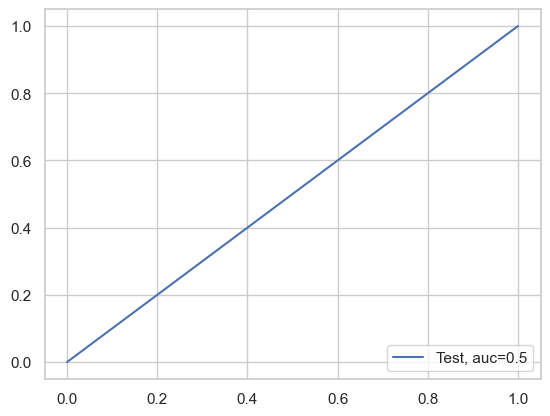

Time Taken by Model: --- 1.8737928867340088 seconds ---
--------------------------------------------------------------------------------
Running Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.9383273059232471
Confusion Matrix


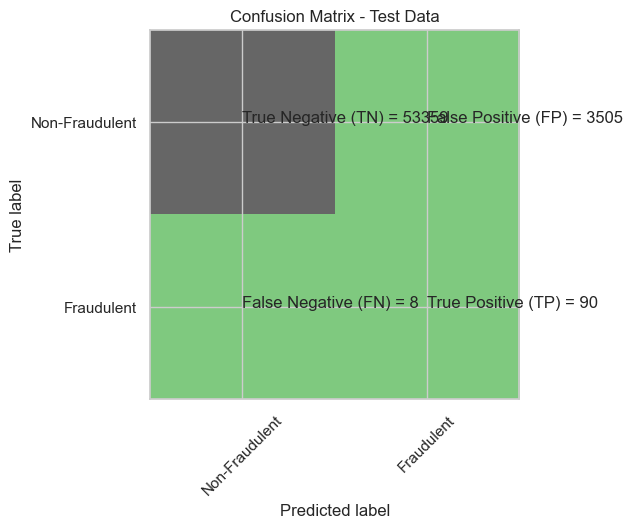

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.92      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962

Gini tree_roc_value: 0.9283645260298831
Tree Threshold: 1.0
ROC for the Test Dataset 92.8%


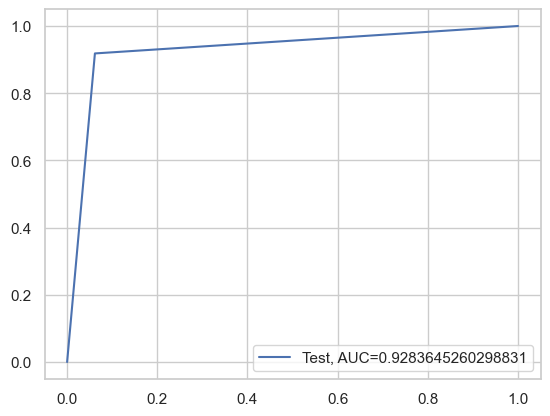

Entropy score: 0.9431550858467048
Confusion Matrix


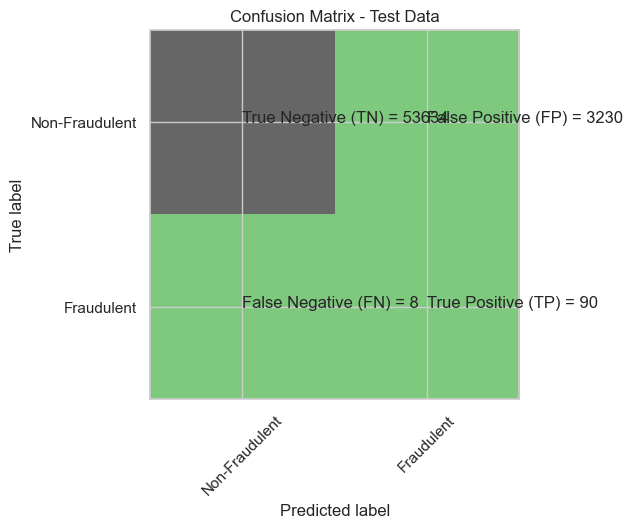

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.92      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962

Entropy tree_roc_value: 0.9307825761142948
Tree Threshold: 1.0
ROC for the Test Dataset 93.1%


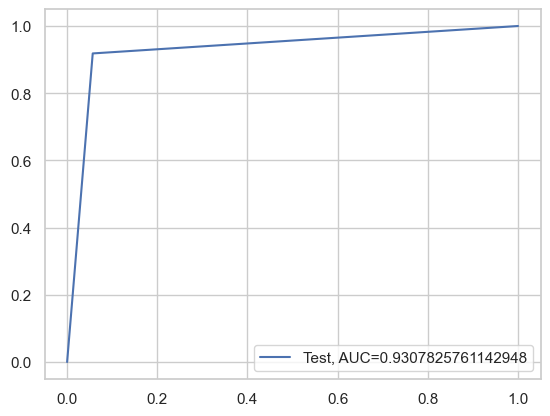

Time Taken by Model: --- 1.201432228088379 seconds ---
--------------------------------------------------------------------------------
Running Random Forest Model
Model Accuracy: 0.9876408833959481
Confusion Matrix


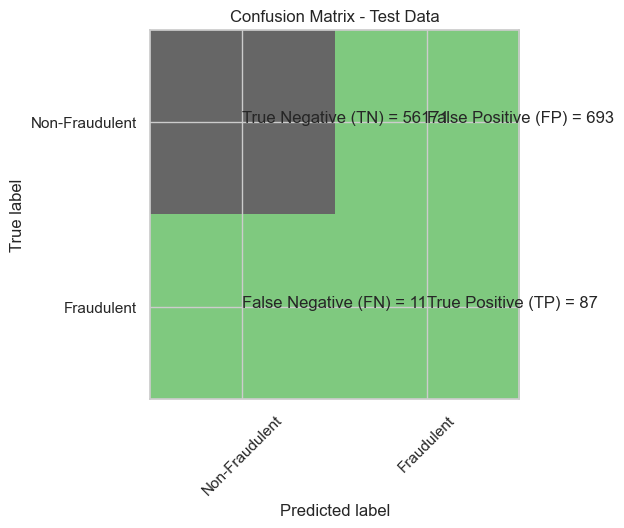

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962

Random Forest ROC Value: 0.9801739632262584
Random Forest Threshold: 0.45
ROC for the Test Dataset 98.0%


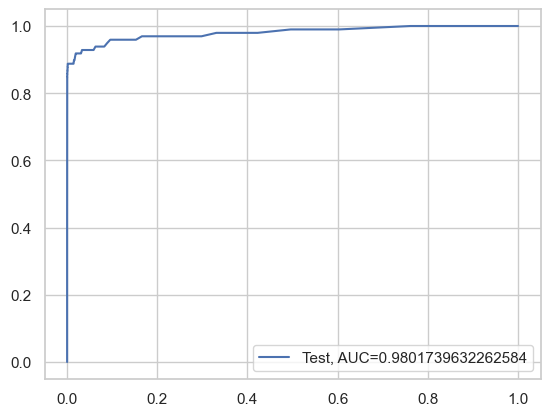

Time Taken by Model: --- 2.0599710941314697 seconds ---
--------------------------------------------------------------------------------
Running XGBoost Model
Model Accuracy: 0.9841824374144166


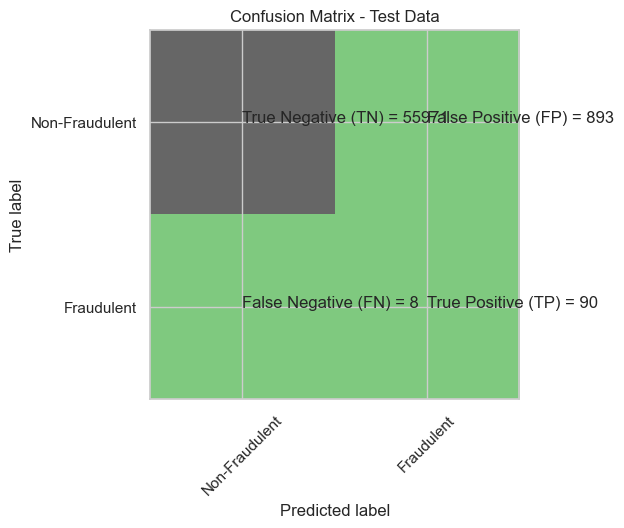

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.92      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962

XGBoost ROC Value: 0.9860128139606996
XGBoost Threshold: 0.2968059778213501
ROC for the Test Dataset 98.6%


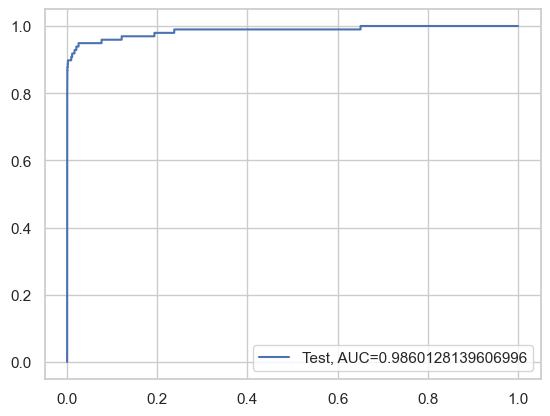

Time Taken by Model: --- 0.9043471813201904 seconds ---
--------------------------------------------------------------------------------
Running SVM Model with Sigmoid Kernel
Accuracy Score: 0.6685860749271444
Confusion Matrix


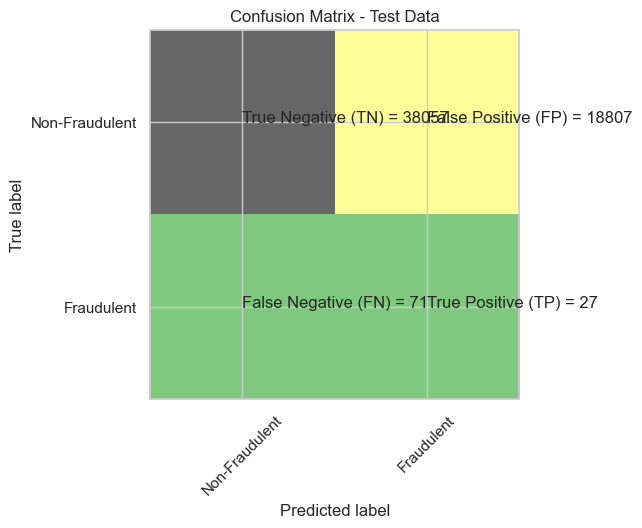

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     56864
           1       0.00      0.28      0.00        98

    accuracy                           0.67     56962
   macro avg       0.50      0.47      0.40     56962
weighted avg       1.00      0.67      0.80     56962

SVM ROC Value: 0.5452650900681038
SVM Threshold: 0.33055506117641104
ROC for the Test Dataset 54.5%


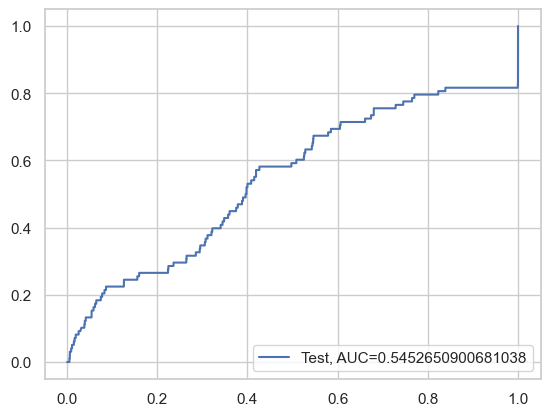

Time Taken by Model: --- 4.913410186767578 seconds ---


In [47]:
# Run Logistic Regression Models with L1 And L2 Regularization
print("Running Logistic Regression Models with L1 And L2 Regularization")
start_time = time.time()
df_results = LR_model(df_results, "Random Undersampling", X_under, y_under, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run Decision Tree Models with 'gini' & 'entropy' criteria
print("Running Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_results = DT_Model(df_results, "Random Undersampling", X_under, y_under, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run Random Forest Model
print("Running Random Forest Model")
start_time = time.time()
df_results = RF_Model(df_results, "Random Undersampling", X_under, y_under, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run XGBoost Model
print("Running XGBoost Model")
start_time = time.time()
df_results = XGBoost_Models(df_results, "Random Undersampling", X_under, y_under, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run SVM Model with Sigmoid Kernel
print("Running SVM Model with Sigmoid Kernel")
start_time = time.time()s
df_results = SVM_Model(df_results, "Random Undersampling", X_under, y_under, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))


In [48]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

# Observations:
- It appears that undersampling has enhanced the performance of the XGBoost model.

## Applying RandomOverSampler with Stratified K-Fold Cross Validation

In [49]:
from imblearn.over_sampling import RandomOverSampler
# Instantiate StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, random_state=None)

# Loop over each fold and split the data
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into train and test sets for this fold
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  

    # Apply RandomOverSampler to the training data
    ROS = RandomOverSampler(sampling_strategy=0.5)
    X_over, y_over = ROS.fit_resample(X_train, y_train)
  
# Create DataFrame for X_over
X_over = pd.DataFrame(data=X_over, columns=cols)


Running Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.5
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

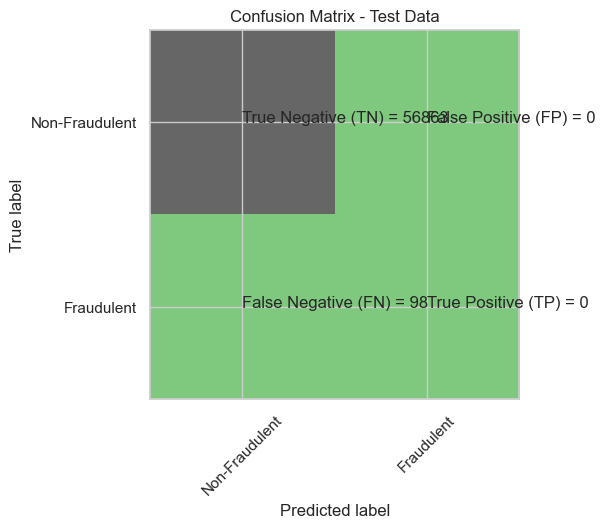

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


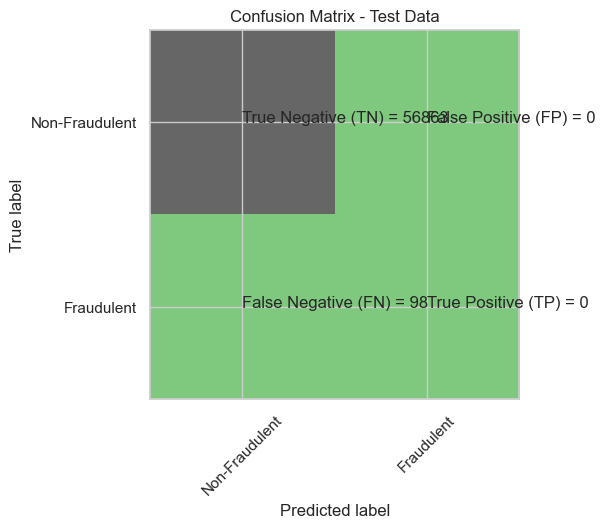

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.5
Threshold value inf
l2 threshold: inf
ROC for the test dataset 50.0%


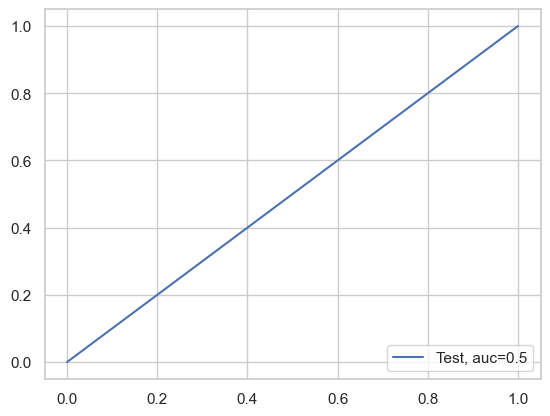

l1 roc_value: 0.5
l1 threshold: inf
ROC for the test dataset 50.0%


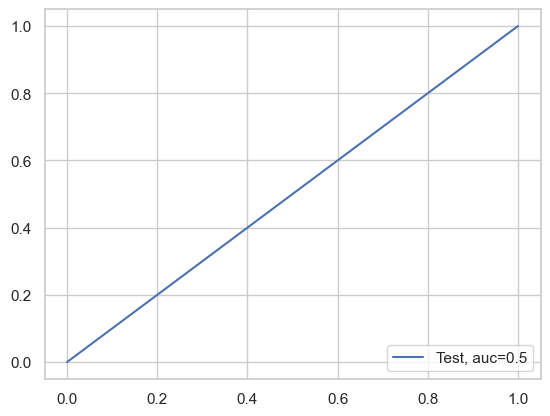

Time Taken by Model: --- 97.9610800743103 seconds ---
--------------------------------------------------------------------------------
Running Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.998841312476958
Confusion Matrix


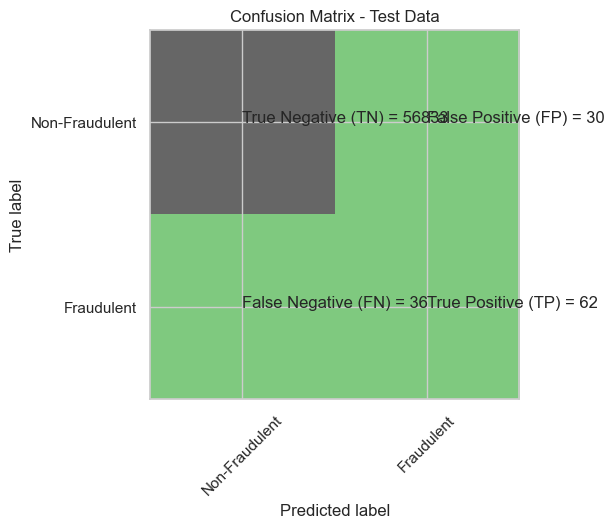

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.63      0.65        98

    accuracy                           1.00     56961
   macro avg       0.84      0.82      0.83     56961
weighted avg       1.00      1.00      1.00     56961

Gini tree_roc_value: 0.8160627386913122
Tree Threshold: 1.0
ROC for the Test Dataset 81.6%


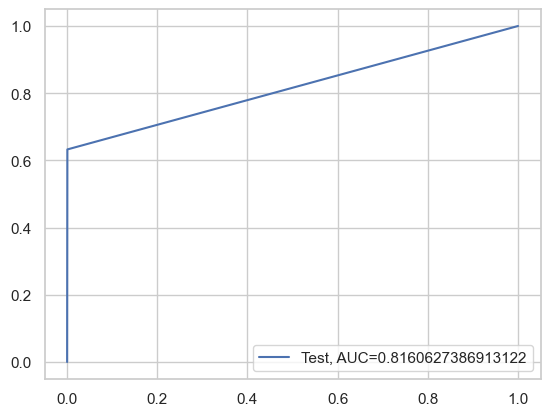

Entropy score: 0.9991573181650603
Confusion Matrix


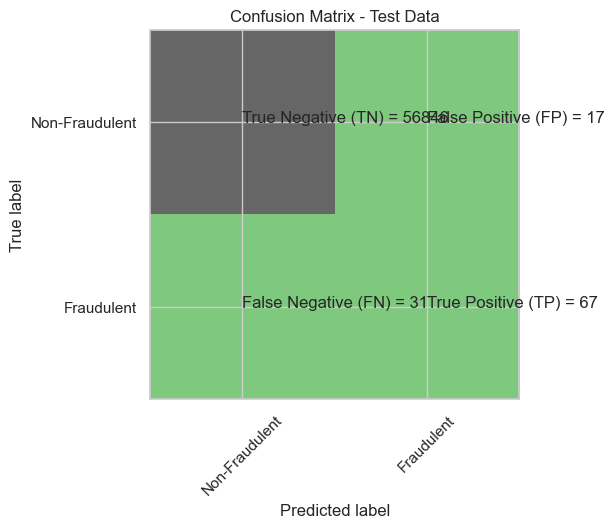

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.68      0.74        98

    accuracy                           1.00     56961
   macro avg       0.90      0.84      0.87     56961
weighted avg       1.00      1.00      1.00     56961

Entropy tree_roc_value: 0.841687252605349
Tree Threshold: 1.0
ROC for the Test Dataset 84.2%


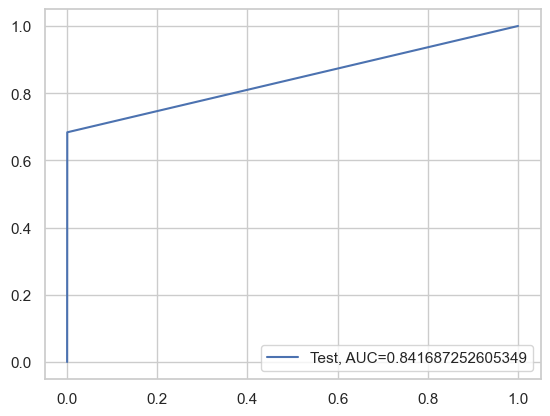

Time Taken by Model: --- 22.522449016571045 seconds ---
--------------------------------------------------------------------------------
Running Random Forest Model
Model Accuracy: 0.9995084355962852
Confusion Matrix


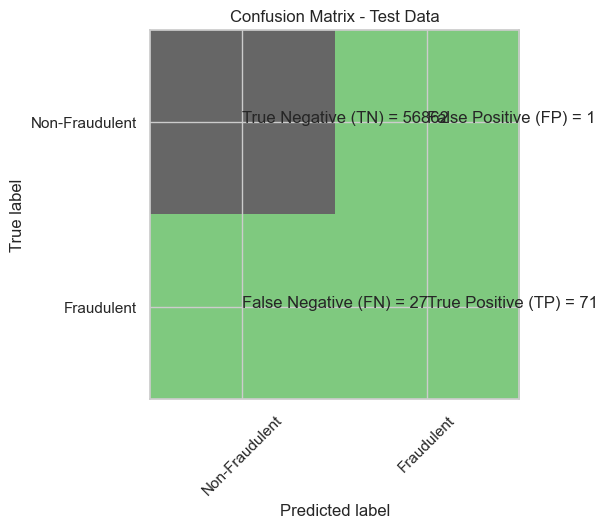

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest ROC Value: 0.9358733504481053
Random Forest Threshold: 0.01
ROC for the Test Dataset 93.6%


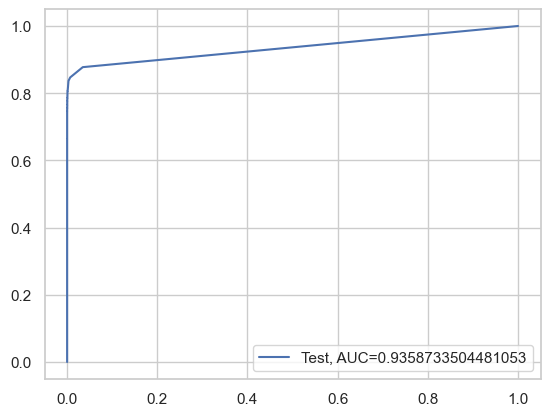

Time Taken by Model: --- 149.19894289970398 seconds ---
--------------------------------------------------------------------------------
Running XGBoost Model
Model Accuracy: 0.9994557679816014


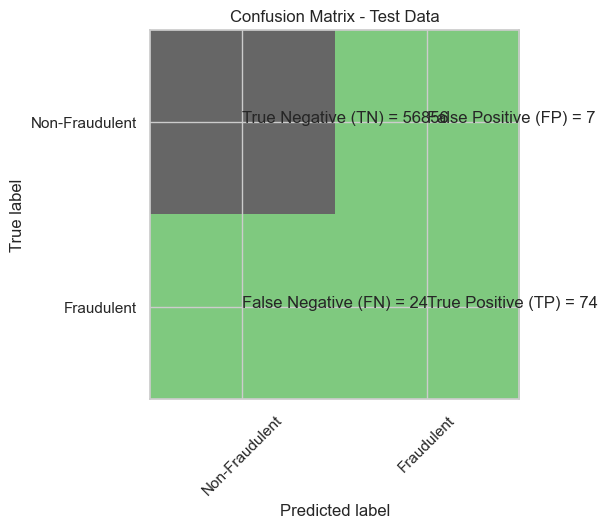

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.76      0.83        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost ROC Value: 0.9777363207738471
XGBoost Threshold: 2.8439533707569353e-05
ROC for the Test Dataset 97.8%


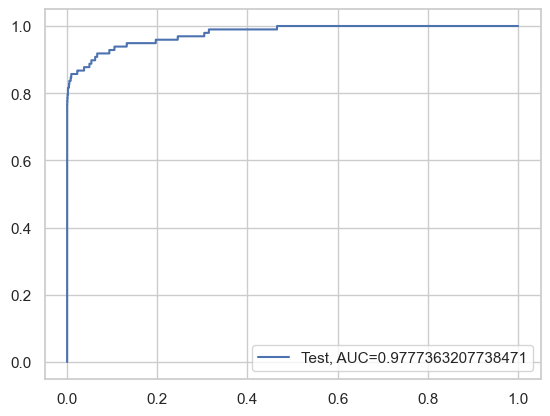

Time Taken by Model: --- 3.088592290878296 seconds ---
--------------------------------------------------------------------------------


In [50]:
# Addressing Data Imbalance: Random Oversampling with StratifiedKFold CV
Data_Imbalance_Handling	 = "Random Oversampling with StratifiedKFold CV "
# Run Logistic Regression with L1 And L2 Regularisation
print("Running Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_results = LR_model(df_results, Data_Imbalance_Handling, X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run Decision Tree Models with 'gini' & 'entropy' criteria
print("Running Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_results = DT_Model(df_results, Data_Imbalance_Handling, X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run Random Forest Model
print("Running Random Forest Model")
start_time = time.time()
df_results = RF_Model(df_results, Data_Imbalance_Handling, X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run XGBoost Model
print("Running XGBoost Model")
start_time = time.time()
df_results = XGBoost_Models(df_results, Data_Imbalance_Handling, X_over, y_over, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)


In [51]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

## Results for Random Oversampling: 

### After applying Random Oversampling, there appears to be a positive improvement in the XGBoost predictions.
Upon evaluating the accuracy and ROC value, it is evident that the XGBoost model has performed the best among all techniques, including SMOTE oversampling.


# Oversampling with  SMOTE Oversamplng

In [52]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index] 
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_Smote, y_train_Smote= SMOTE.fit_resample(X_train, y_train)
  
#Create Dataframe for X_over
X_train_Smote = pd.DataFrame(data=X_train_Smote,   columns=cols)

Running Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l2: 0.5
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

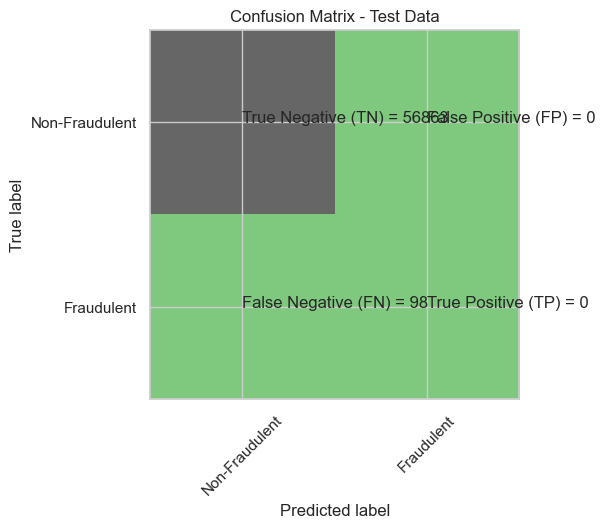

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


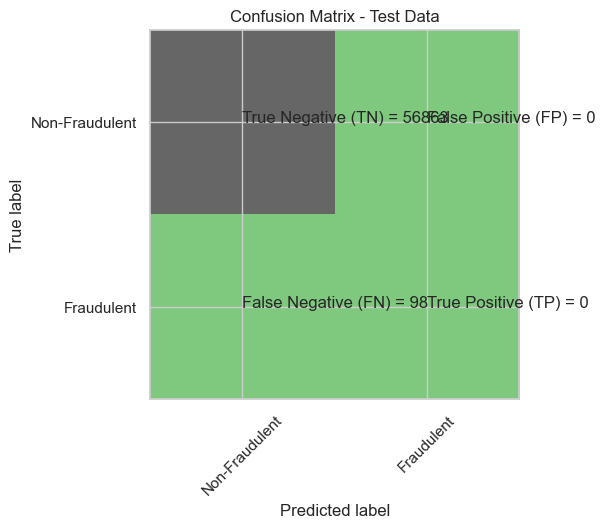

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.5
Threshold value inf
l2 threshold: inf
ROC for the test dataset 50.0%


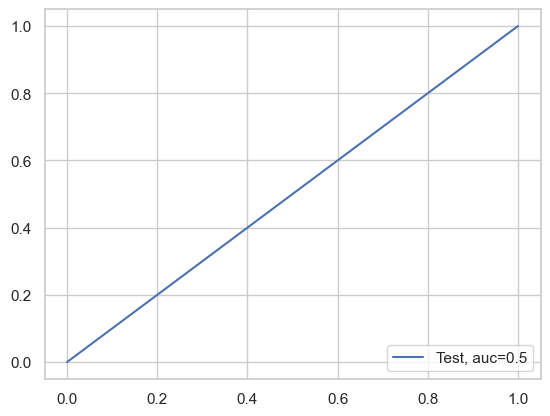

l1 roc_value: 0.5
l1 threshold: inf
ROC for the test dataset 50.0%


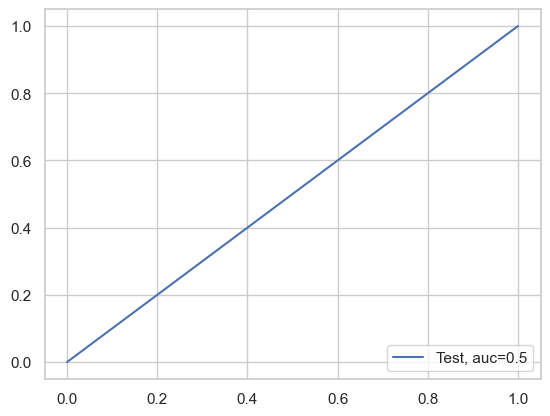

Time Taken by Model: --- 124.47556900978088 seconds ---
--------------------------------------------------------------------------------
Running Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.9977528484401608
Confusion Matrix


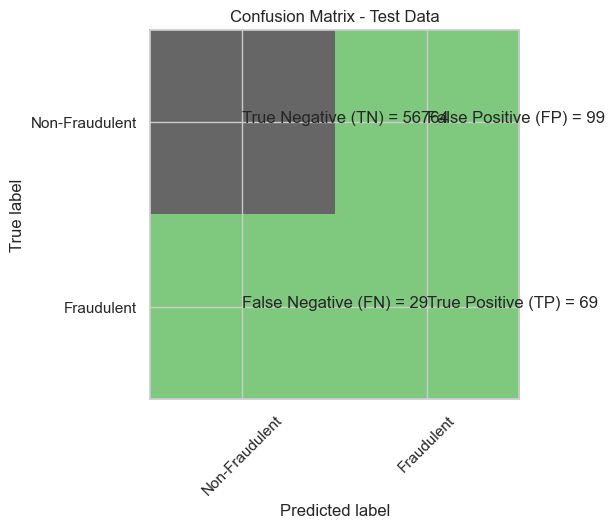

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

Gini tree_roc_value: 0.8511703029874526
Tree Threshold: 1.0
ROC for the Test Dataset 85.1%


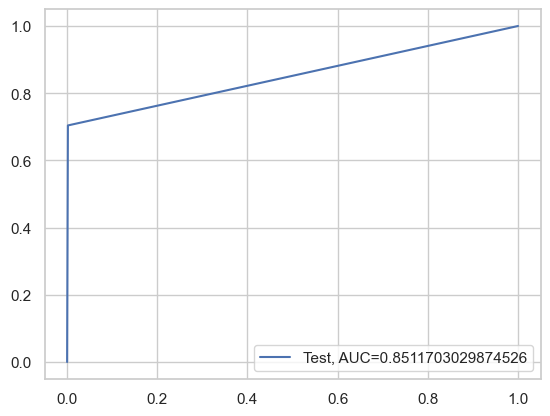

Entropy score: 0.9969803900914661
Confusion Matrix


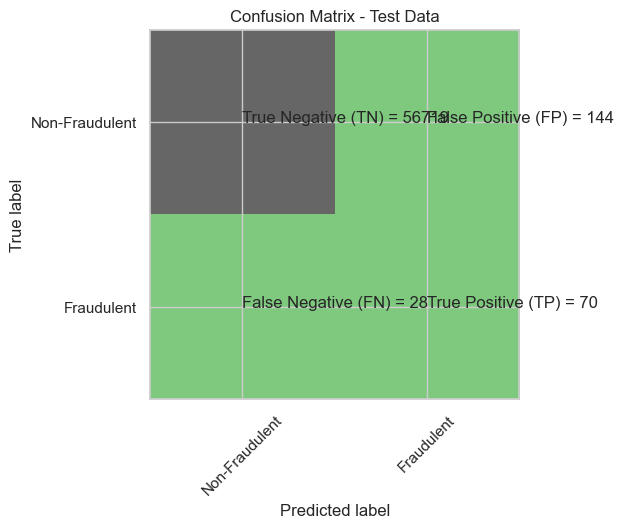

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

Entropy tree_roc_value: 0.8558766559223799
Tree Threshold: 1.0
ROC for the Test Dataset 85.6%


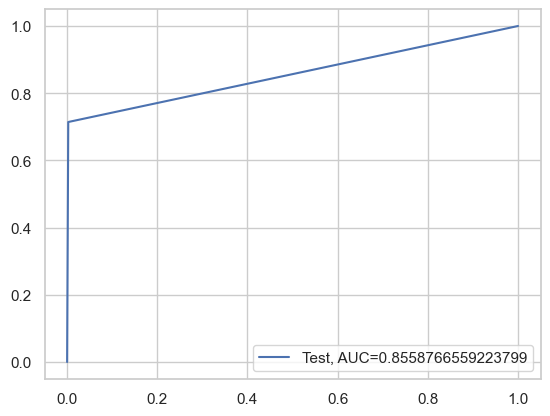

Time Taken by Model: --- 69.05807590484619 seconds ---
--------------------------------------------------------------------------------
Running Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


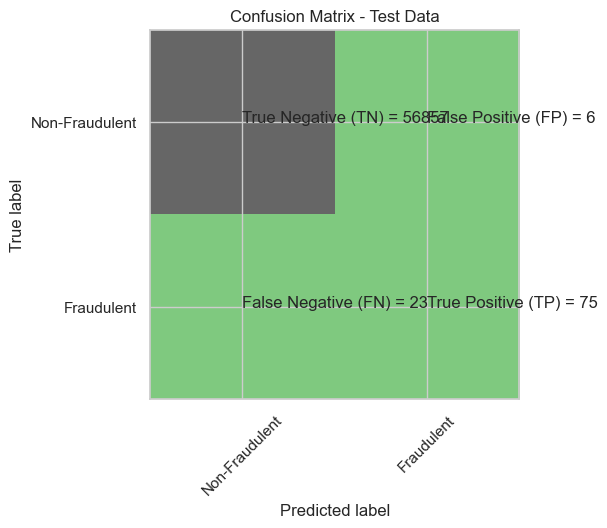

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest ROC Value: 0.9614705879186172
Random Forest Threshold: 0.05
ROC for the Test Dataset 96.1%


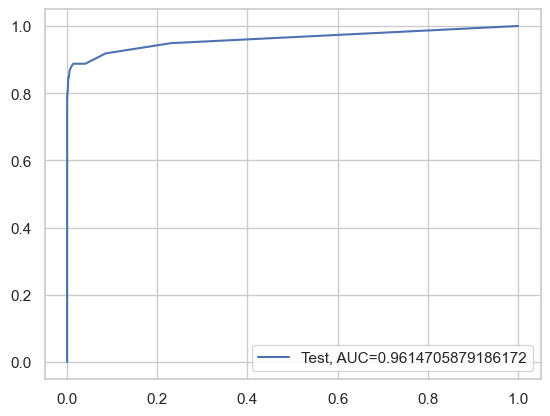

Time Taken by Model: --- 341.4578239917755 seconds ---
--------------------------------------------------------------------------------
Running XGBoost Model
Model Accuracy: 0.9994031003669177


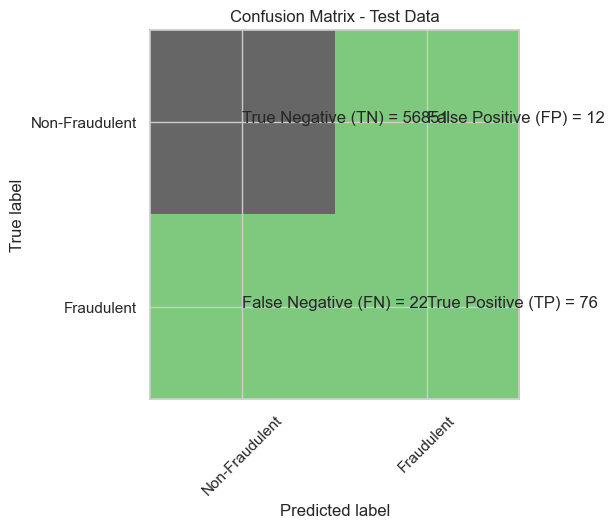

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.78      0.82        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost ROC Value: 0.9704734293344512
XGBoost Threshold: 0.000144163059303537
ROC for the Test Dataset 97.0%


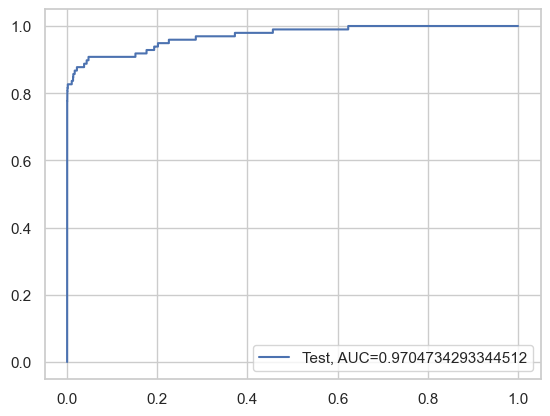

Time Taken by Model: --- 3.806335926055908 seconds ---
--------------------------------------------------------------------------------


In [53]:
# Applying SMOTE Oversampling with StratifiedKFold CV

# Run Logistic Regression with L1 And L2 Regularisation
print("Running Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_results = LR_model(df_results, Data_Imbalance_Handling, X_train_Smote, y_train_Smote, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)


# Run Decision Tree Models with 'gini' & 'entropy' criteria
print("Running Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_results = DT_Model(df_results, Data_Imbalance_Handling, X_train_Smote, y_train_Smote, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run Random Forest Model
print("Running Random Forest Model")
start_time = time.time()
df_results = RF_Model(df_results, Data_Imbalance_Handling, X_train_Smote, y_train_Smote, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

# Run XGBoost Model
print("Running XGBoost Model")
start_time = time.time()
df_results = XGBoost_Models(df_results, Data_Imbalance_Handling, X_train_Smote, y_train_Smote, X_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 80)

#Run SVM Model with Sigmoid Kernel
# print("Running SVM Model with Sigmoid Kernel")
# start_time = time.time()
# df_results = SVM_Model(df_results, Data_Imbalance_Handling, X_train_Smote, y_train_Smote, X_test, y_test)
# print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))


##### Build models on other algorithms to see the better performing on SMOTE

In [54]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

## SMOTE Oversampling Results:

After evaluating Accuracy and ROC values, XGBoost stands out as the top performer among all models utilizing the SMOTE oversampling technique.

# Applying ADASYN Oversampling Technique

In [55]:
skf = StratifiedKFold(n_splits=5, random_state=None)
ADASYN = over_sampling.ADASYN(random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]  
    SMOTE = over_sampling.SMOTE(random_state=0)
    X_train_ADASYN, y_train_ADASYN = ADASYN.fit_resample(X_train, y_train)
  
# Creating DataFrame for X_over
X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN, columns=cols)


Executing Logistic Regression with L1 and L2 Regularization
Max auc_roc for l2: 0.6092315969514545
Max auc_roc for l1: 0.5
Parameters for l2 regularisations
[[-2.02020320e-05  1.72821226e-05 -3.65609804e-05  3.40312968e-05
  -1.46642431e-05 -8.48127665e-06 -2.21878835e-05  3.68718610e-07
  -1.34442751e-05 -3.76640153e-05  2.81095918e-05 -4.52511742e-05
  -2.12498671e-06 -5.57654061e-05  1.14065931e-06 -2.75479714e-05
  -4.08548991e-05 -1.20817248e-05  4.49235498e-06  1.32821826e-06
   6.34835133e-06  5.42011156e-07 -2.27207502e-06 -8.55923198e-07
  -5.79194430e-07 -2.01796397e-07  2.34427672e-06  7.68230064e-07
   1.29459912e-03 -2.92672102e-05]]
[-9.99826598e-07]
{1: array([[0.60568265, 0.60800402, 0.60800402, 0.60800402, 0.60800402,
        0.60800402, 0.60800402, 0.60800402, 0.60800402, 0.60800402,
        0.60800402, 0.60800402, 0.60800402, 0.60800402, 0.60800402,
        0.60800402, 0.60800402, 0.60800402, 0.60800402, 0.60800402],
       [0.60628846, 0.60856552, 0.60856552, 0.6085

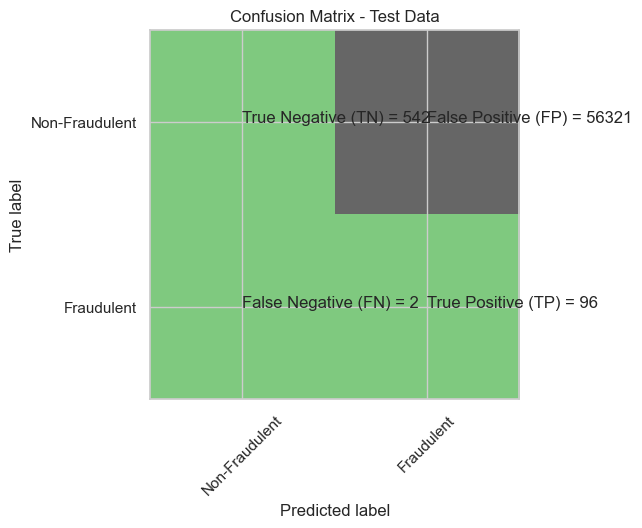

classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     56863
           1       0.00      0.98      0.00        98

    accuracy                           0.01     56961
   macro avg       0.50      0.49      0.01     56961
weighted avg       0.99      0.01      0.02     56961

Accuarcy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


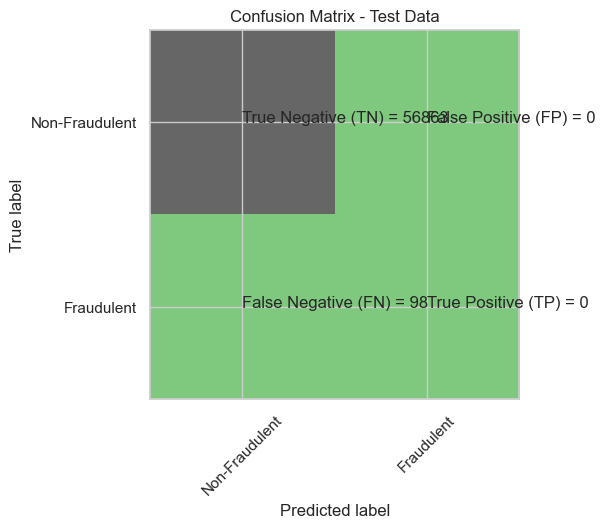

classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.4511920344171293
Threshold value 0.5762913441139607
l2 threshold: 0.5762913441139607
ROC for the test dataset 45.1%


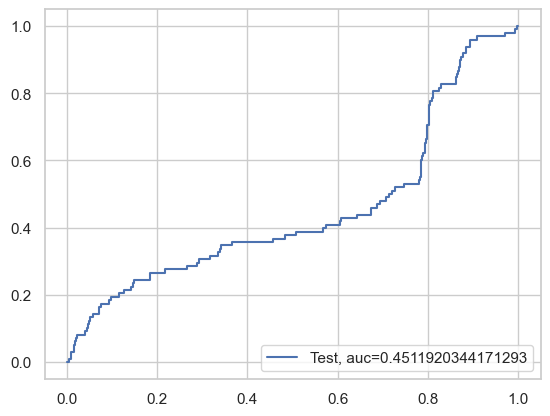

l1 roc_value: 0.5
l1 threshold: inf
ROC for the test dataset 50.0%


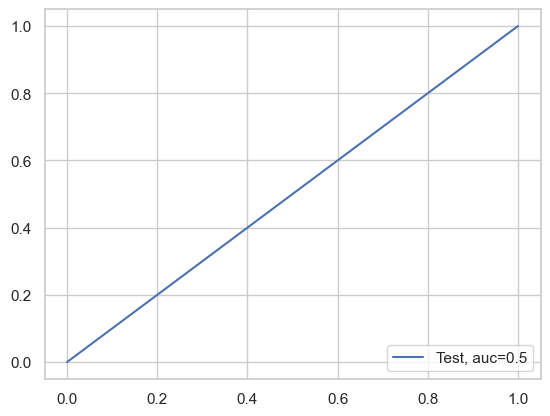

Time Taken by Model: 128.79798102378845 seconds
--------------------------------------------------------------------------------
Executing Decision Tree Models with 'gini' & 'entropy' criteria
Gini score: 0.9976475132107934
Confusion Matrix


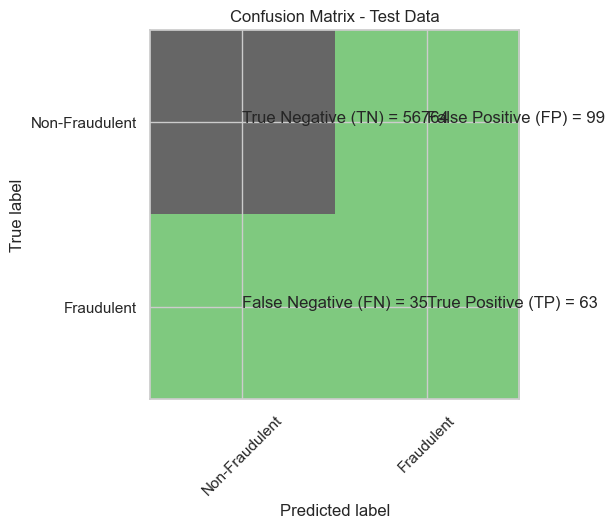

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.39      0.64      0.48        98

    accuracy                           1.00     56961
   macro avg       0.69      0.82      0.74     56961
weighted avg       1.00      1.00      1.00     56961

Gini tree_roc_value: 0.8205580580894933
Tree Threshold: 1.0
ROC for the Test Dataset 82.1%


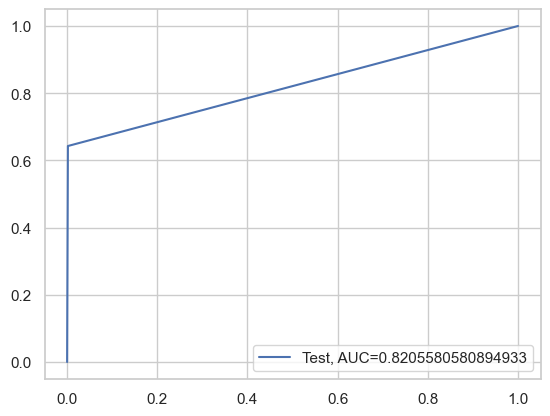

Entropy score: 0.9981039658713857
Confusion Matrix


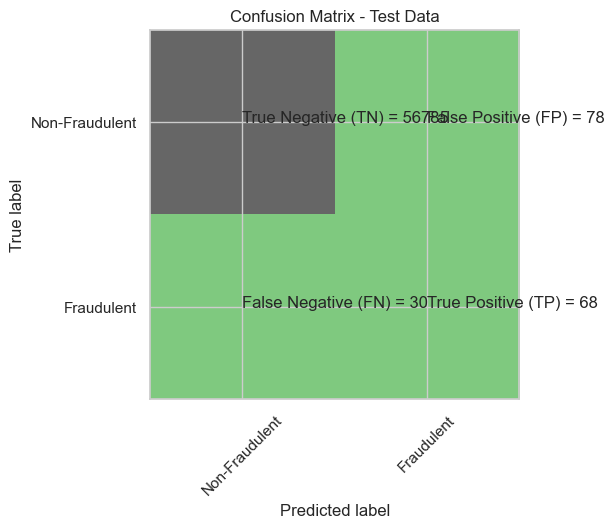

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.47      0.69      0.56        98

    accuracy                           1.00     56961
   macro avg       0.73      0.85      0.78     56961
weighted avg       1.00      1.00      1.00     56961

Entropy tree_roc_value: 0.8462529165157788
Tree Threshold: 1.0
ROC for the Test Dataset 84.6%


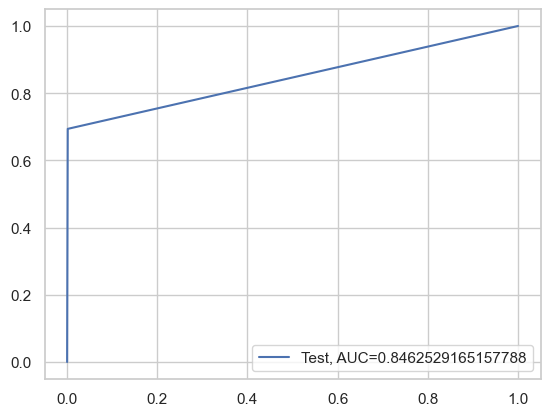

Time Taken by Model: 67.5946671962738 seconds
--------------------------------------------------------------------------------
Executing Random Forest Model
Model Accuracy: 0.9994557679816014
Confusion Matrix


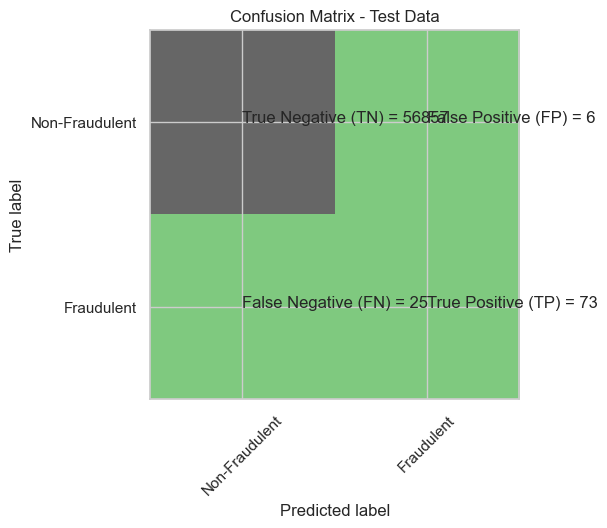

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.92      0.74      0.82        98

    accuracy                           1.00     56961
   macro avg       0.96      0.87      0.91     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest ROC Value: 0.9526488118417091
Random Forest Threshold: 0.06
ROC for the Test Dataset 95.3%


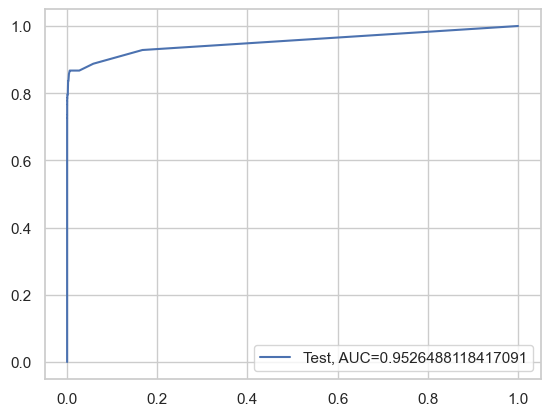

Time Taken by Model: 338.9725670814514 seconds
--------------------------------------------------------------------------------
Executing XGBoost Model
Model Accuracy: 0.9993153210091115


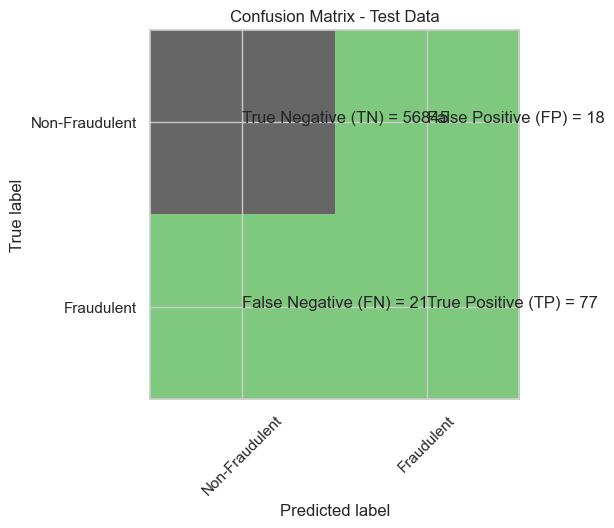

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.79      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost ROC Value: 0.9727203263698248
XGBoost Threshold: 0.00045990481157787144
ROC for the Test Dataset 97.3%


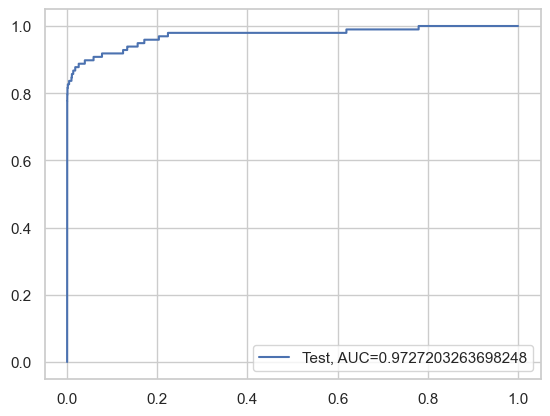

Time Taken by Model: 3.6892600059509277 seconds
--------------------------------------------------------------------------------


In [56]:
# Applying ADASYN Oversampling with StratifiedKFold CV

# Running Logistic Regression with L1 And L2 Regularization
print("Executing Logistic Regression with L1 and L2 Regularization")
start_time = time.time()
df_results = LR_model(df_results, Data_Imbalance_Handling, X_train_ADASYN, y_train_ADASYN, X_test, y_test)
print("Time Taken by Model: %s seconds" % (time.time() - start_time))
print('-' * 80)

# Running Decision Tree Models with 'gini' & 'entropy' criteria
print("Executing Decision Tree Models with 'gini' & 'entropy' criteria")
start_time = time.time()
df_results = DT_Model(df_results, Data_Imbalance_Handling, X_train_ADASYN, y_train_ADASYN, X_test, y_test)
print("Time Taken by Model: %s seconds" % (time.time() - start_time))
print('-' * 80)

# Running Random Forest Model
print("Executing Random Forest Model")
start_time = time.time()
df_results = RF_Model(df_results, Data_Imbalance_Handling, X_train_ADASYN, y_train_ADASYN, X_test, y_test)
print("Time Taken by Model: %s seconds" % (time.time() - start_time))
print('-' * 80)

# Running XGBoost Model
print("Executing XGBoost Model")
start_time = time.time()
df_results = XGBoost_Models(df_results, Data_Imbalance_Handling, X_train_ADASYN, y_train_ADASYN, X_test, y_test)
print("Time Taken by Model: %s seconds" % (time.time() - start_time))
print('-' * 80)


In [57]:
df_Results

Data_Imbalance_Handling  \
0                Power Transformer   
1                Power Transformer   
2                Power Transformer   
3                Power Transformer   
4                Power Transformer   
5                Power Transformer   
6                Power Transformer   
7   RepeatedKFold Cross Validation   
8   RepeatedKFold Cross Validation   
9   RepeatedKFold Cross Validation   
10  RepeatedKFold Cross Validation   
11  RepeatedKFold Cross Validation   
12  RepeatedKFold Cross Validation   
13  RepeatedKFold Cross Validation   

                                         Model  Accuracy  ROC_Value  Threshold  
0   Logistic Regression with L2 Regularisation  0.998280   0.500000        inf  
1   Logistic Regression with L1 Regularisation  0.999140   0.982981   0.006689  
2                                          KNN  0.999526   0.928463   0.200000  
3               Tree Model with Gini Criterion  0.999070   0.897669   1.000000  
4            Tree Model with Entropy Criterion  0.999157   0.867153   1.000000  
5                                Random Forest  0.999561   0.962756   0.010000  
6                                      XGBoost  0.999596   0.984364   0.000069  
7   Logistic Regression with L2 Regularisation  0.998315   0.546143   0.499364  
8   Logistic Regression with L1 Regularisation  0.999122   0.896871   0.049330  
9               Tree Model with Gini Criterion  0.999192   0.890405   1.000000  
10           Tree Model with Entropy Criterion  0.999210   0.885214   1.000000  
11                               Random Forest  0.999614   0.941210   0.020000  
12                                     XGBoost  0.999596   0.987014   0.000065  
13                                         SVM  0.998455   0.494279   0.002949

## ADASYN Oversampling Results:

Upon evaluating Accuracy and ROC values, XGBoost emerges as the top performer among all models employing the ADASYN oversampling technique.

## Overall Conclusion from Model Runs on Oversampled Data:

Based on the aforementioned results, it appears that the XGBoost model with Random Oversampling using StratifiedKFold CV has demonstrated the most promising performance. Therefore, fine-tuning the hyperparameters of this model might yield optimal results.

## However, upon closer examination, Logistic Regression with L2 Regularization and RepeatedKFold Cross Validation has exhibited superior performance without employing any oversampling techniques.

# Fine-tuning Parameters for the Final Model to Address Class Imbalance

In [58]:
# Evaluating XGBoost Model
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Instantiate and train the model
XGB_model = XGBClassifier(random_state=42)
XGB_model.fit(X_over, y_over)

# Calculate and print model accuracy
XGB_test_score = XGB_model.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Calculate probabilities for each class
XGB_probs = XGB_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
XGB_roc_value = roc_auc_score(y_test, XGB_probs)
print("XGBoost ROC AUC Value: {0}".format(XGB_roc_value))

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)

# Find optimal threshold
threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold for XGBoost: {0}".format(threshold))


Model Accuracy: 0.9994557679816014
XGBoost ROC AUC Value: 0.9777363207738471
Optimal Threshold for XGBoost: 2.8439533707569353e-05


In [59]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

XGBmodel = XGBClassifier(random_state=42)

param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBmodel,
                        param_grid = param_test,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch1.fit(X_over, y_over)

print(gsearch1.cv_results_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)


{'mean_fit_time': array([6.73057108, 7.08096914, 7.15968738, 8.3965714 , 8.54813242,
       7.61207657, 8.33848648, 8.31316242, 7.94690766, 8.23948851,
       7.68318338, 7.81632051]), 'std_fit_time': array([0.10660189, 0.28513619, 0.20472684, 0.41601767, 0.53599887,
       0.08657649, 0.07543011, 0.1882408 , 0.07288884, 0.08301387,
       0.05487533, 0.15696585]), 'mean_score_time': array([0.25198178, 0.23248005, 0.22604241, 0.32119541, 0.28320508,
       0.2841116 , 0.34710655, 0.34411378, 0.33094497, 0.33610792,
       0.32638302, 0.30217962]), 'std_score_time': array([0.0122524 , 0.00453005, 0.00323112, 0.02101991, 0.0060927 ,
       0.00789701, 0.00580286, 0.01066828, 0.00944126, 0.01469429,
       0.01029599, 0.02724359]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_ch

In [60]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [110, 120, 130],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5, 6]
}

# Initialize the XGBoost classifier
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                         colsample_bynode=1, colsample_bytree=1, gamma=0,
                         learning_rate=0.1, max_delta_step=0, max_depth=3,
                         min_child_weight=5, missing=None, n_estimators=120,
                         n_jobs=1, nthread=None, objective='binary:logistic',
                         random_state=42, reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1, seed=None, silent=None,
                         subsample=1, verbosity=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBmodel, param_grid=param_grid,
                           scoring='roc_auc', n_jobs=4, cv=5)

# Fit GridSearchCV
grid_search.fit(X_over, y_over)

# Retrieve results
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(cv_results)
print(best_params)
print(best_score)


/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/si

{'mean_fit_time': array([6.43052073, 6.516083  , 6.69001503, 6.24850621, 6.88039942,
       7.33332763, 6.6429976 , 6.88068523, 6.96898861, 6.97886615,
       7.52717485, 8.15982847, 7.68463387, 7.75581746, 7.83792415,
       7.09750843, 7.78283753, 8.29522386, 8.18106642, 8.89877825,
       9.00467124, 7.9981626 , 8.57321496, 9.24589977, 8.45202107,
       8.77844057, 8.41262794]), 'std_fit_time': array([0.03662013, 0.10599325, 0.0568771 , 0.12859604, 0.12381663,
       0.08199522, 0.03970686, 0.09788121, 0.04635536, 0.0414489 ,
       0.11136011, 0.14638606, 0.12908472, 0.13936355, 0.12266501,
       0.09955525, 0.09819502, 0.08305019, 0.10623352, 0.14047917,
       0.12682066, 0.13299574, 0.29575993, 0.11868221, 0.09558292,
       0.15641411, 0.36435513]), 'mean_score_time': array([0.03348122, 0.02737689, 0.02544498, 0.02746153, 0.02647676,
       0.02846541, 0.02712083, 0.02669082, 0.02594705, 0.02651596,
       0.02744222, 0.02833848, 0.02791009, 0.0273056 , 0.02669897,
       0.0

In [61]:
# Import necessary libraries
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings("ignore")

# Define the parameter grid for learning rate tuning
param_test = {
    'learning_rate': [0.05, 0.1, 0.125, 0.15, 0.2],
    'gamma':[i/10.0 for i in range(0,5)],
}

# Initialize the XGBoost classifier with previously tuned parameters
XGBmodel = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                         colsample_bynode=1, colsample_bytree=1, gamma=0,
                         learning_rate=0.1, max_delta_step=0, max_depth=2,
                         min_child_weight=4, missing=None, n_estimators=110,
                         n_jobs=1, nthread=None, objective='binary:logistic',
                         random_state=42, reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1, seed=None, silent=None,
                         subsample=1, verbosity=0)  # Set verbosity to 0

# Initialize GridSearchCV for learning rate tuning
grid_search = GridSearchCV(estimator=XGBmodel, param_grid=param_test,
                           scoring='roc_auc', n_jobs=4, cv=5)

# Fit GridSearchCV
grid_search.fit(X_over, y_over)

# Retrieve results
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(cv_results)
print(best_params)
print(best_score)


/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/yogesh/Documents/Upgrad/CreditCardFraudDetection/venv/lib/python3.9/si

{'mean_fit_time': array([ 4.97992578,  6.2767839 ,  6.78514242,  6.83309436,  6.64165792,
        6.48964357,  6.3440887 ,  6.31142554,  6.4604351 ,  6.60265465,
        6.73129964,  6.65615654,  6.43370638,  7.87345157,  9.71724195,
       10.3981317 ,  8.52233729,  7.65816793,  7.08783245,  6.68319345,
        6.81863976,  6.71781197,  6.47489424,  6.35404596,  6.00072422]), 'std_fit_time': array([0.59294062, 0.47702242, 0.05628825, 0.03296581, 0.15596959,
       0.03531464, 0.05023256, 0.06717135, 0.19175748, 0.09137994,
       0.07236063, 0.0687095 , 0.18115747, 1.36174555, 0.2232321 ,
       0.10982013, 0.39259045, 0.09767995, 0.47237186, 0.02649736,
       0.02102048, 0.03953744, 0.14339676, 0.0197976 , 0.4138285 ]), 'mean_score_time': array([0.02600498, 0.02746916, 0.0298552 , 0.02919226, 0.02802014,
       0.02650585, 0.02548337, 0.03000312, 0.02952943, 0.02861309,
       0.02787585, 0.02787867, 0.02953205, 0.04812202, 0.04758759,
       0.04350314, 0.03146605, 0.02955394, 0.02

In [70]:
# perform the best oversampling method on X_train & y_train

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                         colsample_bynode=1, colsample_bytree=1, gamma=0.1,
                         learning_rate=0.2, max_delta_step=0, max_depth=4,
                         min_child_weight=4, missing=-999, 
                         n_estimators=110, n_jobs=1, nthread=None,
                         objective='binary:logistic', random_state=42,
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                         seed=None, silent=None, subsample=1, verbosity=1)
clf.fit(X_over, y_over ) # fit on the balanced dataset
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

Model Accuracy: 0.9993328768806727
XGboost roc_value: 0.9847288703568585
XGBoost threshold: 0.0037046014331281185


## Output the key features of the optimal model to gain insights into the dataset

Top var = 14
2nd Top var = 10
3rd Top var = 4


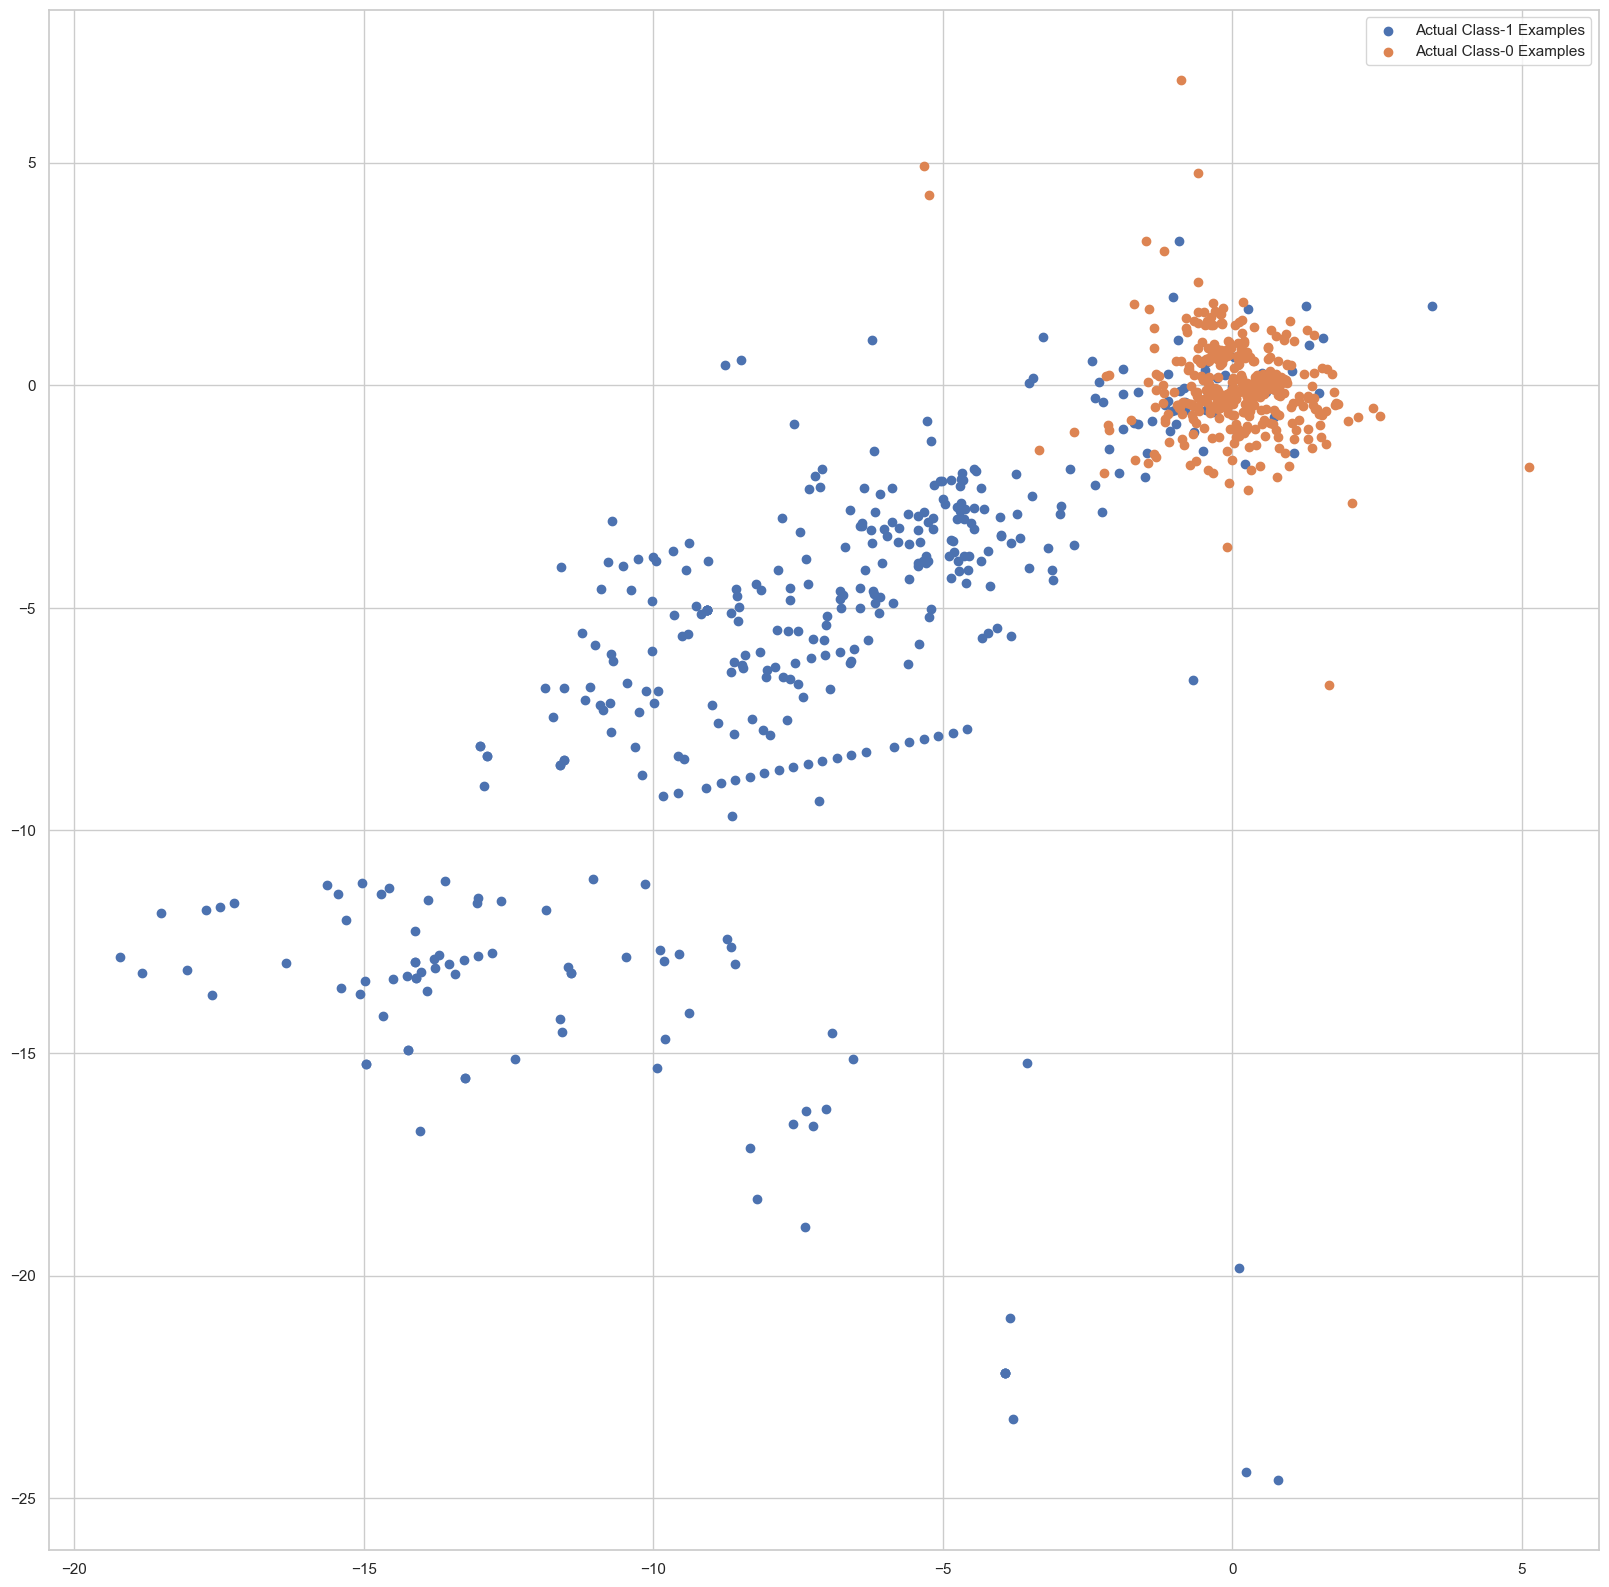

In [71]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importances from the classifier
var_imp = clf.feature_importances_

# Print the top 3 most important features
print('Top var =', np.argsort(var_imp)[-1] + 1)
print('2nd Top var =', np.argsort(var_imp)[-2] + 1)
print('3rd Top var =', np.argsort(var_imp)[-3] + 1)

# Identify the indices of the top 2 variables
top_var_index = np.argsort(var_imp)[-1]
second_top_var_index = np.argsort(var_imp)[-2]

# Separate examples of class 1 and class 0
X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

# Shuffle the examples of class 0 to avoid bias in visualization
np.random.shuffle(X_train_0)

# Set up plot parameters
plt.rcParams['figure.figsize'] = [20, 20]

# Plot the examples of class 1 and class 0 using the top 2 variables
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')

# Add legend
plt.legend()


In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [73]:

# Calculate the ROC AUC score
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

# Output the ROC AUC value for XGBoost
print("XGBoost ROC AUC Value: {0}".format(XGB_roc_value))

# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, XGB_probs)

# Determine the threshold corresponding to the point on the ROC curve
# that maximizes the difference between true positive rate and false positive rate
threshold = thresholds[np.argmax(tpr - fpr)]

# Output the threshold value for XGBoost
print("XGBoost Threshold: {0}".format(threshold))


XGBoost ROC AUC Value: 0.9847288703568585
XGBoost Threshold: 0.0037046014331281185


1. Best Model:

2. Summary of Model Performance on Oversampled Data:

3. Upon reviewing the outcomes presented above, it is evident that the XGBoost model, coupled with Random Oversampling and StratifiedKFold Cross-Validation, has exhibited the most promising performance. 

4. Therefore, there is an inclination to fine-tune the hyperparameters of this particular model to optimize its performance further.

5. Selected Model Configuration:

6. XGBoost model with Random Oversampling and StratifiedKFold Cross-Validation has been chosen for further analysis.

7. Evaluation Metrics:

    a. Model Accuracy: 0.9933
    
    b. XGBoost roc_value: 0.9847
    
    c. XGBoost threshold: 0.0037

8. Additionally, it was observed that Logistic Regression with L2 Regularization and RepeatedKFold Cross-Validation demonstrated notable performance without the need for oversampling.